Q.1. Use the taxi trip dataset to find clusters of locations that might belong to a particular cluster having similar kinds of trip features. Use DBSCAN algo for this.

Show the locations belonging to each cluster over a map.

Perform the analysis of trips belonging to the same clusters and point out the distinguishing features and insights.

Also, divide a day in 1-hour slot and show a time of day based analysis of each cluster

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ed5P_zz0aAUuG85mFFd0YyKxVkHWdZvK
To: /content/yellow_tripdata_2023-01.parquet
100% 47.7M/47.7M [00:00<00:00, 77.0MB/s]


In [ ]:
!pip install dask_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import dask.dataframe as dd
from sklearn.cluster import DBSCAN
from geopy.geocoders import Nominatim
import geopandas as gpd
import folium
import itertools
df = dd.read_parquet('/content/yellow_tripdata_2023-01.parquet')

In [ ]:
df_pandas = df.compute()
df_pandas.dropna()
data = df_pandas.sample(n=100000, random_state=1)

In [ ]:
taxi_zones = gpd.read_file('/content/taxi_zones.shp')
pickup_zones = taxi_zones[['LocationID', 'geometry']].rename(columns={'LocationID': 'PULocationID'})
dropoff_zones = taxi_zones[['LocationID', 'geometry']].rename(columns={'LocationID': 'DOLocationID'})
data_with_pickup_geometry = pd.merge(data, pickup_zones, on='PULocationID', how='left')
data_with_dropoff_geometry = pd.merge(data_with_pickup_geometry, dropoff_zones, on='DOLocationID', how='left')
data_with_dropoff_geometry = gpd.GeoDataFrame(data_with_dropoff_geometry)
data_with_dropoff_geometry = data_with_dropoff_geometry.dropna(subset=['geometry_x', 'geometry_y'])
# Converting pickup location geometry to WGS84
data_with_dropoff_geometry['geometry_x'] = data_with_dropoff_geometry['geometry_x'].to_crs(epsg=4326)
# Converting dropoff location geometry to WGS84
data_with_dropoff_geometry['geometry_y'] = data_with_dropoff_geometry['geometry_y'].to_crs(epsg=4326)
# Extracting longitude and latitude
data_with_dropoff_geometry['pickup_longitude'] = data_with_dropoff_geometry['geometry_x'].centroid.x
data_with_dropoff_geometry['pickup_latitude'] = data_with_dropoff_geometry['geometry_x'].centroid.y
data_with_dropoff_geometry['dropoff_longitude'] = data_with_dropoff_geometry['geometry_y'].centroid.x
data_with_dropoff_geometry['dropoff_latitude'] = data_with_dropoff_geometry['geometry_y'].centroid.y
# Drop redundant columns
data_with_coordinates = data_with_dropoff_geometry.drop(columns=['geometry_x', 'geometry_y'])

<ipython-input-3-3363ee9e6920>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_with_dropoff_geometry['pickup_longitude'] = data_with_dropoff_geometry['geometry_x'].centroid.x
<ipython-input-3-3363ee9e6920>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_with_dropoff_geometry['pickup_latitude'] = data_with_dropoff_geometry['geometry_x'].centroid.y
<ipython-input-3-3363ee9e6920>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_with_dropoff_geometry['dropoff_longitude'] = data_with_dropoff_geometry['geometry_y'].centroid.x
<ipython-input-3-3363ee9e6920>:

In [ ]:
data_with_coordinates.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-11 00:30:29   2023-01-11 00:38:12              1.0   
1         2  2023-01-16 23:03:54   2023-01-16 23:14:16              2.0   
2         2  2023-01-02 12:36:57   2023-01-02 13:09:49              2.0   
3         2  2023-01-09 08:30:43   2023-01-09 08:54:01              1.0   
4         1  2023-01-13 21:13:09   2023-01-13 21:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.36         1.0                  N           157           157   
1           2.03         1.0                  N           186           229   
2          14.62         1.0                  N           138            87   
3           3.69         1.0                  N           238           233   
4           1.20         1.0                  N            50           163   

   payment_type  ...  tip_amount  tolls_amount  improvement_surcharge  \
0             2  ...        0.00          0.00                    1.0   
1             1  ...        3.56          0.00                    1.0   
2             1  ...        5.00          6.55                    1.0   
3             1  ...        5.46          0.00                    1.0   
4             1  ...        2.55          0.00                    1.0   

   total_amount  congestion_surcharge  airport_fee  pickup_longitude  \
0         11.80                   0.0         0.00        -73.902330   
1         21.36                   2.5         0.00        -73.992438   
2         81.50                   2.5         1.25        -73.873629   
3         32.76                   2.5         0.00        -73.973049   
4         15.45                   2.5         0.00        -73.995135   

   pickup_latitude  dropoff_longitude  dropoff_latitude  
0        40.723995         -73.902330         40.723995  
1        40.748497         -73.965146         40.756729  
2        40.774376         -74.007496         40.706808  
3        40.791705         -73.970443         40.749914  
4        40.766238         -73.977569         40.764421  

[5 rows x 23 columns]

In [ ]:
# DBSCAN for Pickup Location
X = data_with_coordinates[['pickup_longitude', 'pickup_latitude']]
eps = 0.01
min_samples = 150
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)
data_with_coordinates['pickup_cluster'] = labels

In [ ]:
data_with_coordinates[data_with_coordinates["pickup_cluster"] != -1]["pickup_cluster"].nunique()

11

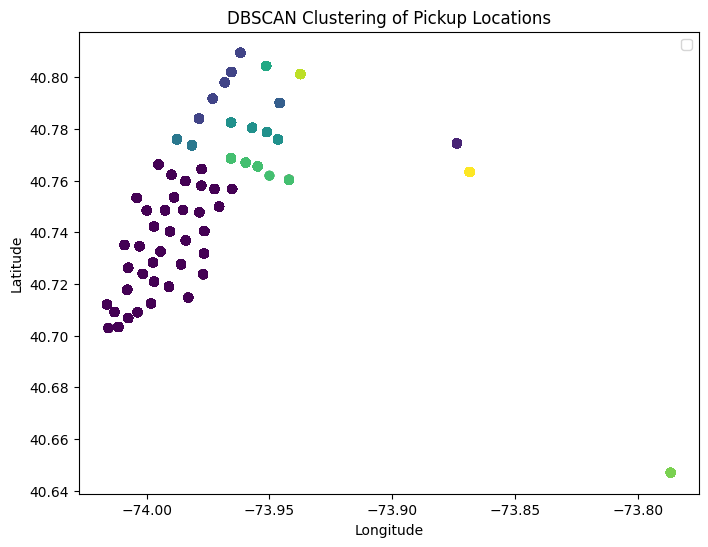

In [ ]:
# DBSCAN Clustering of Pickup Locations'
filtered_data = data_with_coordinates[data_with_coordinates['pickup_cluster'] != -1]
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['pickup_longitude'], filtered_data['pickup_latitude'], c=filtered_data['pickup_cluster'], marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Pickup Locations')
plt.legend()
plt.show()


In [ ]:
# DBSCAN for Dropoff Location
X = data_with_coordinates[['dropoff_longitude', 'dropoff_latitude']]
eps = 0.010
min_samples = 150
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)
data_with_coordinates['drop_cluster'] = labels

In [ ]:
data_with_coordinates[data_with_coordinates["drop_cluster"] != -1]["drop_cluster"].nunique()

24

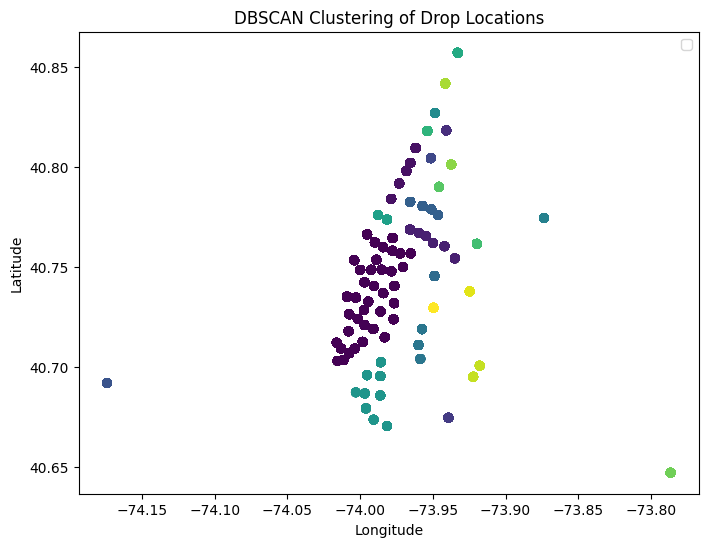

In [ ]:
filtered_data = data_with_coordinates[data_with_coordinates['drop_cluster'] != -1]
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['dropoff_longitude'], filtered_data['dropoff_latitude'], c=filtered_data['drop_cluster'], marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Drop Locations')
plt.legend()
plt.show()

In [ ]:
# Defining empty dictionaries to store cluster coordinates and distances
dropoff_clusters_dict = {}
pickup_clusters_dict = {}
dist_dict = {}
# removing noise
filtered_data = data_with_coordinates[(data_with_coordinates['drop_cluster'] != -1) & (data_with_coordinates['pickup_cluster'] != -1)]
# Calculate mean latitude and longitude for drop-off clusters
dropoff_clusters = filtered_data['drop_cluster'].unique()
for d in dropoff_clusters:
    mean_longitude = filtered_data[filtered_data['drop_cluster'] == d]['dropoff_longitude'].mean()
    mean_latitude = filtered_data[filtered_data['drop_cluster'] == d]['dropoff_latitude'].mean()
    dropoff_clusters_dict[d] = (mean_longitude, mean_latitude)
# Calculate mean latitude and longitude for pickup clusters
pickup_clusters = filtered_data['pickup_cluster'].unique()
for p in pickup_clusters:
    mean_longitude = filtered_data[filtered_data['pickup_cluster'] == p]['pickup_longitude'].mean()
    mean_latitude = filtered_data[filtered_data['pickup_cluster'] == p]['pickup_latitude'].mean()
    pickup_clusters_dict[p] = (mean_longitude, mean_latitude)
# Calculate mean trip distance for each pair of drop-off and pickup clusters
for d, p in itertools.product(dropoff_clusters, pickup_clusters):
    mean_distance = filtered_data[(filtered_data['drop_cluster'] == d) &
                                  (filtered_data['pickup_cluster'] == p)]['trip_distance'].mean()
    dist_dict[(d, p)] = mean_distance
# Display the dictionaries
print("Drop-off Clusters:")
print(dropoff_clusters_dict)
print("\nPickup Clusters:")
print(pickup_clusters_dict)
print("\nMean Trip Distances:")
print(dist_dict)

Drop-off Clusters:
{0: (-73.98805849639648, 40.74447035782482), 1: (-73.9731863324404, 40.79162987412464), 2: (-73.96080050081869, 40.767174688507616), 3: (-73.94077166756267, 40.81825786111926), 4: (-73.93928705867958, 40.67446941826645), 5: (-73.95129200243512, 40.80433394979461), 6: (-74.17400027276302, 40.69183120640151), 7: (-73.95493943403986, 40.77954949479537), 8: (-73.94889145447944, 40.74537943399849), 9: (-73.95855827785762, 40.71408692747708), 10: (-73.87362864289085, 40.77437570593243), 11: (-73.94852173020877, 40.82701265492534), 12: (-73.9888741564427, 40.68669966155705), 13: (-73.98362220297135, 40.77443052257334), 14: (-73.93283148761297, 40.8571082833144), 15: (-73.95378223705629, 40.817975147629454), 16: (-73.91969431946075, 40.76149256216376), 17: (-73.94575026755159, 40.7900107514954), 18: (-73.78653298335003, 40.646984892395274), 19: (-73.93734560812489, 40.80116948058648), 20: (-73.94139910573634, 40.841708771119656), 21: (-73.92057664949789, 40.69702433126702), 

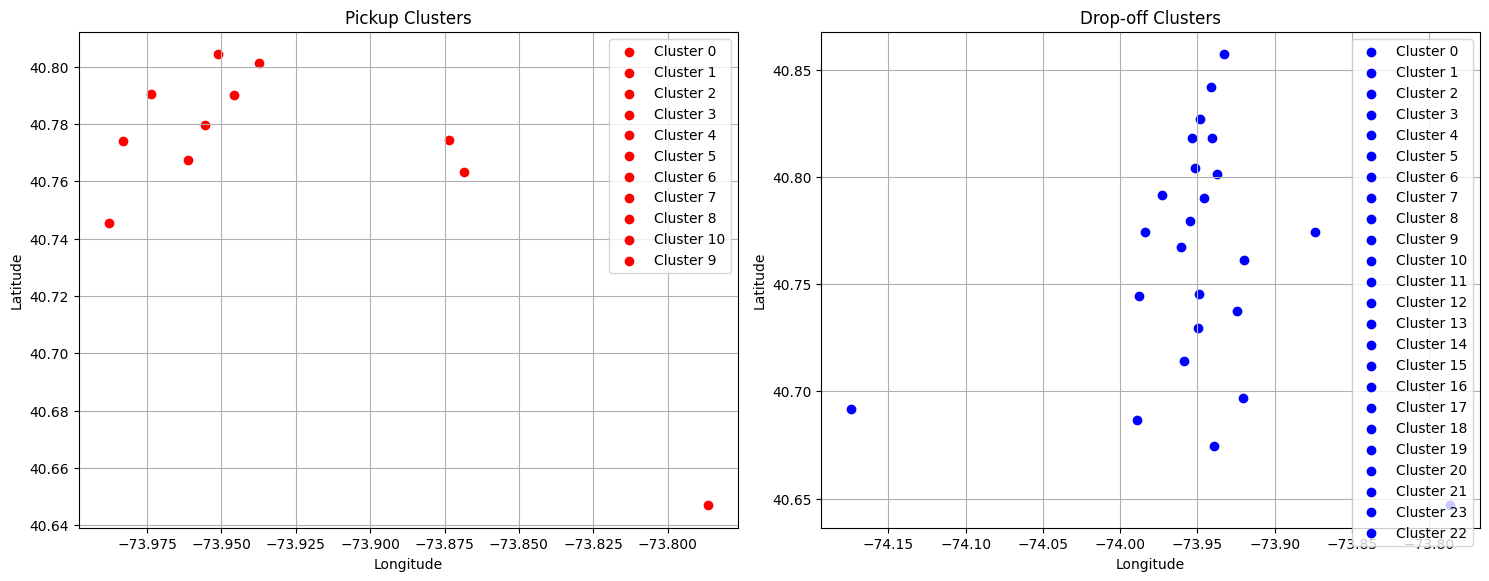

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Plot pickup clusters
for cluster, (longitude, latitude) in pickup_clusters_dict.items():
    if cluster != -1:
        ax1.scatter(longitude, latitude, label=f'Cluster {cluster}', marker='o', color='red')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Pickup Clusters')
ax1.legend()
ax1.grid(True)
# Plot drop-off clusters
for cluster, (longitude, latitude) in dropoff_clusters_dict.items():
    if cluster != -1:
        ax2.scatter(longitude, latitude, label=f'Cluster {cluster}', marker='o', color='blue')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Drop-off Clusters')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

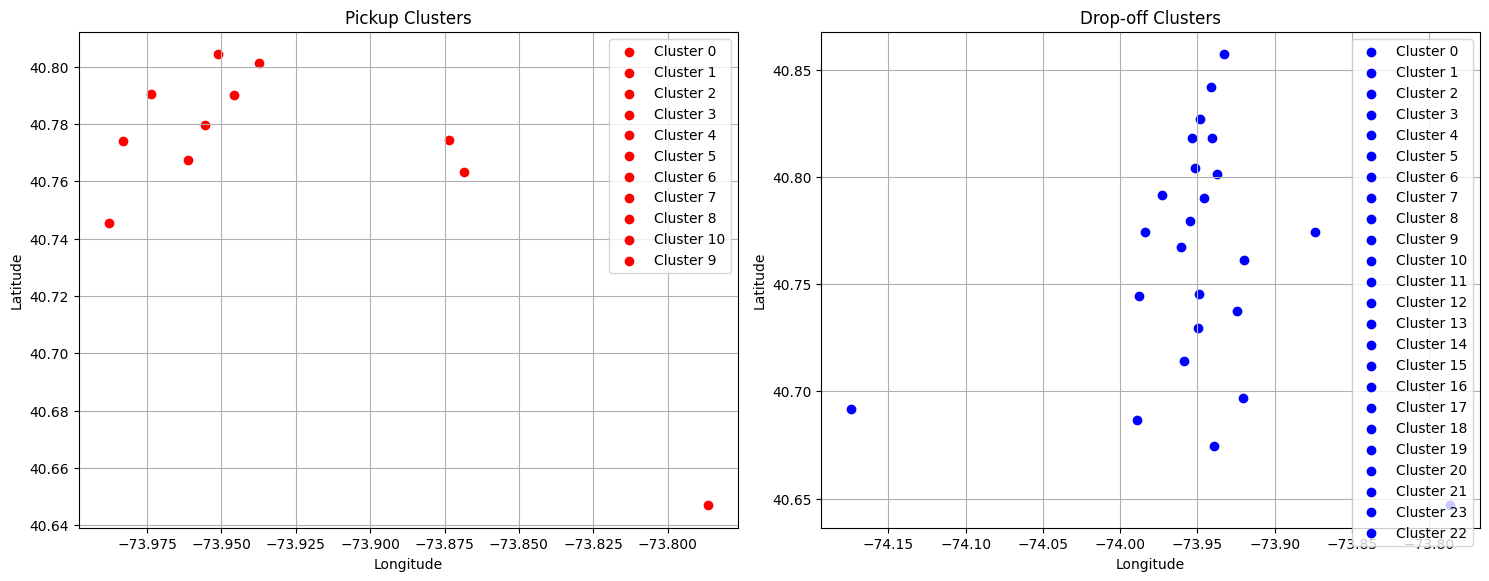

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Plot pickup clusters
for cluster, (longitude, latitude) in pickup_clusters_dict.items():
    if cluster != -1:
        ax1.scatter(longitude, latitude, label=f'Cluster {cluster}', marker='o', color='red')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Pickup Clusters')
ax1.legend()
ax1.grid(True)
# Plot drop-off clusters
for cluster, (longitude, latitude) in dropoff_clusters_dict.items():
    if cluster != -1:
        ax2.scatter(longitude, latitude, label=f'Cluster {cluster}', marker='o', color='blue')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Drop-off Clusters')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

 locations belonging to each cluster over a map

In [ ]:
# Create a map centered at the mean latitude and longitude of all data points
mean_latitude = data_with_coordinates['pickup_latitude'].mean()
mean_longitude = data_with_coordinates['pickup_longitude'].mean()
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10)
# Plot pickup cluster
for cluster, (longitude, latitude) in pickup_clusters_dict.items():
    if cluster != -1:
        folium.Marker([latitude, longitude], popup=f'Pickup Cluster {cluster}', icon=folium.Icon(color='red')).add_to(map)
# Plot drop-off clusters
for cluster, (longitude, latitude) in dropoff_clusters_dict.items():
    if cluster != -1:
        folium.Marker([latitude, longitude], popup=f'Drop-off Cluster {cluster}', icon=folium.Icon(color='blue')).add_to(map)
# Display the map
map


Analysis trips belongs to same cluster

Insights for Pickup Clusters:
Cluster 0:
	mean_trip_distance: 2.511011065955912
	median_trip_distance: 1.69
	mean_fare_amount: 15.40161010538168
	median_fare_amount: 12.1
	location_name: 361, 7th Avenue, Chelsea, Manhattan, New York County, New York, 10001, United States
Cluster 1:
	mean_trip_distance: 9.467313746065058
	median_trip_distance: 9.5
	mean_fare_amount: 40.211420076949985
	median_fare_amount: 40.8
	location_name: Runway Drive, Queens County, New York, 11371, United States
Cluster 2:
	mean_trip_distance: 2.2851559832376225
	median_trip_distance: 1.7
	mean_fare_amount: 14.115292565575041
	median_fare_amount: 12.1
	location_name: 206, West 92nd Street, Manhattan Community Board 7, Manhattan, New York County, New York, 10025, United States
Cluster 3:
	mean_trip_distance: 2.3937102473498237
	median_trip_distance: 1.61
	mean_fare_amount: 15.11351590106007
	median_fare_amount: 12.1
	location_name: 1878, 3rd Avenue, Manhattan Community Board 11, Manhattan, New York County, New York

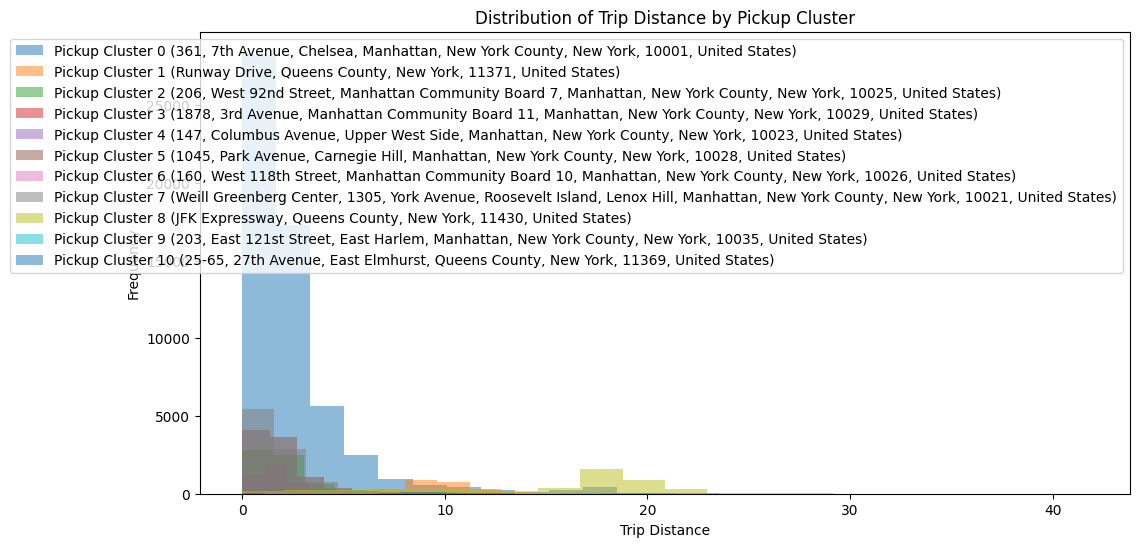

In [ ]:
pick_cl = data_with_coordinates.groupby('pickup_cluster')
drop_cl = data_with_coordinates.groupby('drop_cluster')
geoloc = Nominatim(user_agent="reverse_geocoder")
# Define a function to get location name from coordinates
def get_location_name(latitude, longitude):
    loc = geoloc.reverse((latitude, longitude), language='en')
    if loc is not None:
        return loc.address
    else:
        return "Unknown location"
pick_cl_dic ={}
for cluster, group in pick_cl:
    if cluster != -1:
        insights = {
            'mean_trip_distance': group['trip_distance'].mean(),
            'median_trip_distance': group['trip_distance'].median(),
            'mean_fare_amount': group['fare_amount'].mean(),
            'median_fare_amount': group['fare_amount'].median(),

        }
        latitude = group['pickup_latitude'].iloc[0]
        longitude = group['pickup_longitude'].iloc[0]
        location_name = get_location_name(latitude, longitude)
        insights['location_name'] = location_name
        pick_cl_dic[cluster] = insights

drop_cl_dic = {}
for cluster, group in drop_cl:
    if cluster != -1:
        insights = {
            'mean_trip_distance': group['trip_distance'].mean(),
            'median_trip_distance': group['trip_distance'].median(),
            'mean_fare_amount': group['fare_amount'].mean(),
            'median_fare_amount': group['fare_amount'].median(),
        }
        latitude = group['dropoff_latitude'].iloc[0]
        longitude = group['dropoff_longitude'].iloc[0]
        location_name = get_location_name(latitude, longitude)
        insights['location_name'] = location_name
        drop_cl_dic[cluster] = insights

print("Insights for Pickup Clusters:")
for cluster, insights in pick_cl_dic.items():
    print(f"Cluster {cluster}:")
    for stat, value in insights.items():
        print(f"\t{stat}: {value}")

print("\nInsights for Drop-off Clusters:")
for cluster, insights in drop_cl_dic.items():
    print(f"Cluster {cluster}:")
    for stat, value in insights.items():
        print(f"\t{stat}: {value}")

# Visualize distributions
plt.figure(figsize=(12, 6))
for cluster, group in pick_cl:
    if cluster != -1:
        location_name = pick_cl_dic[cluster]['location_name']
        plt.hist(group['trip_distance'], bins=20, alpha=0.5, label=f'Pickup Cluster {cluster} ({location_name})')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Distance by Pickup Cluster')
plt.legend()
plt.show()

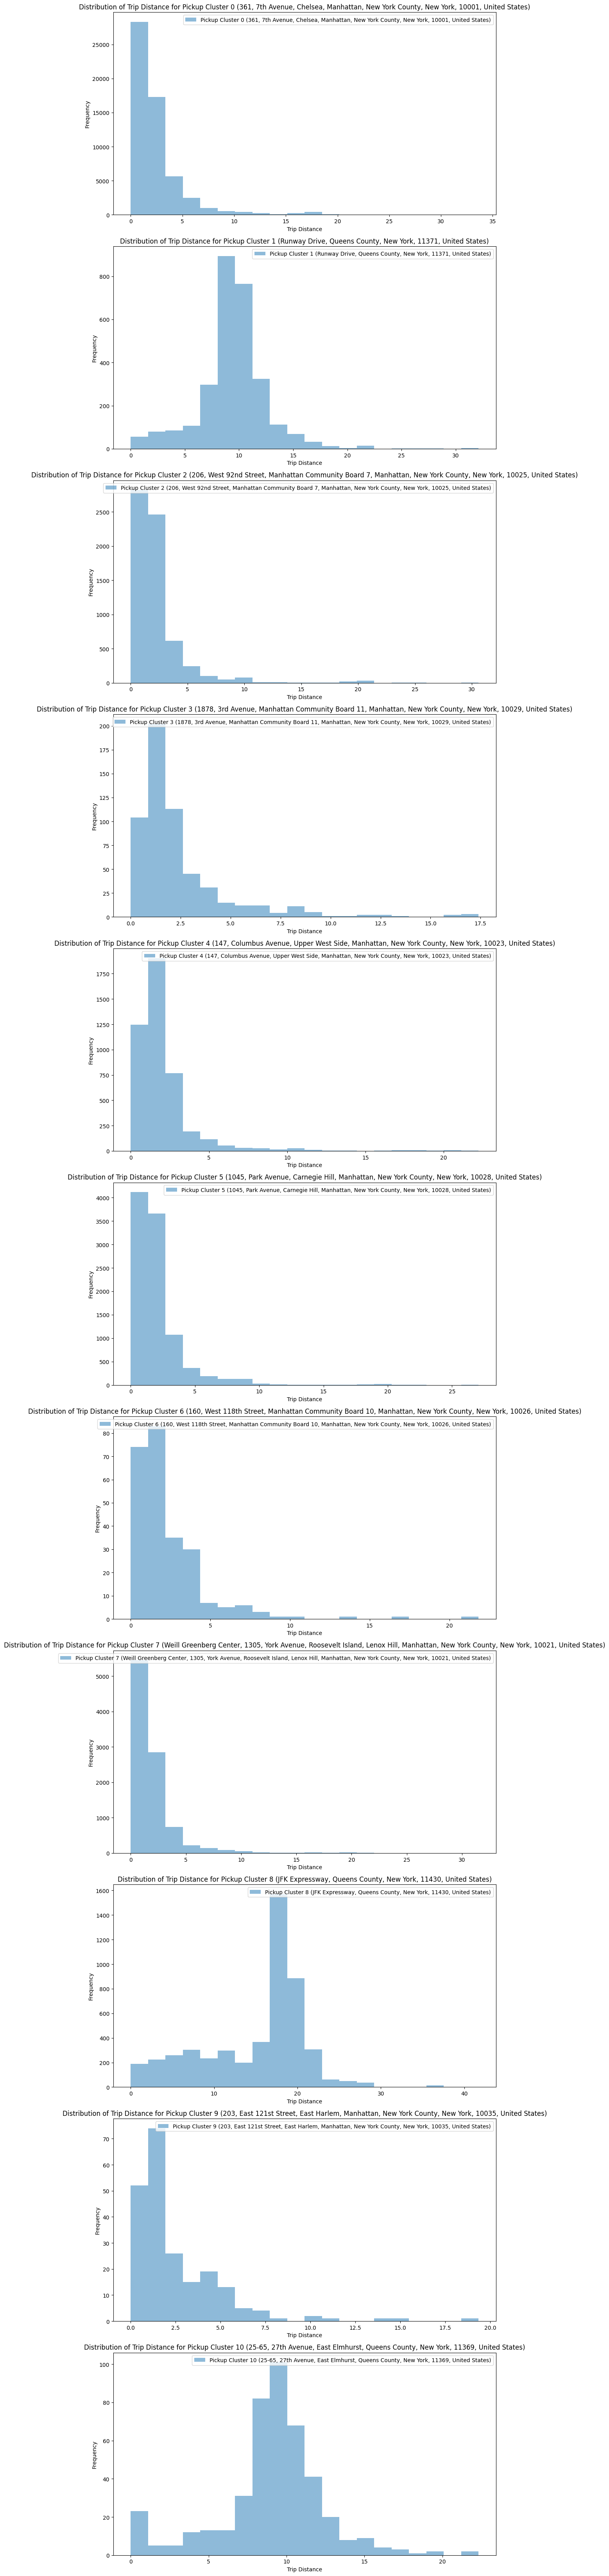

In [ ]:
n_cl = len([c for c, _ in pick_cl if c != -1])
fig, axs = plt.subplots(n_cl, figsize=(12, 6*n_cl))
sub_index = 0

for cl, group in pick_cl:
    if cl != -1:
        location_name = pick_cl_dic[cl]['location_name']
        axs[sub_index].hist(group['trip_distance'], bins=20, alpha=0.5, label=f'Pickup Cluster {cl} ({location_name})')
        axs[sub_index].set_xlabel('Trip Distance')
        axs[sub_index].set_ylabel('Frequency')
        axs[sub_index].set_title(f'Distribution of Trip Distance for Pickup Cluster {cl} ({location_name})')
        axs[sub_index].legend()
        sub_index += 1

plt.tight_layout()
plt.show()


From the analysis of passenger frequency and distance, we found that the majority of trips cover a distance ranging from 0 to 30 km.
Furthermore, the most frequent trip distance falls within the range of 0 to 10 km.

Time of day based analysis of each cluster

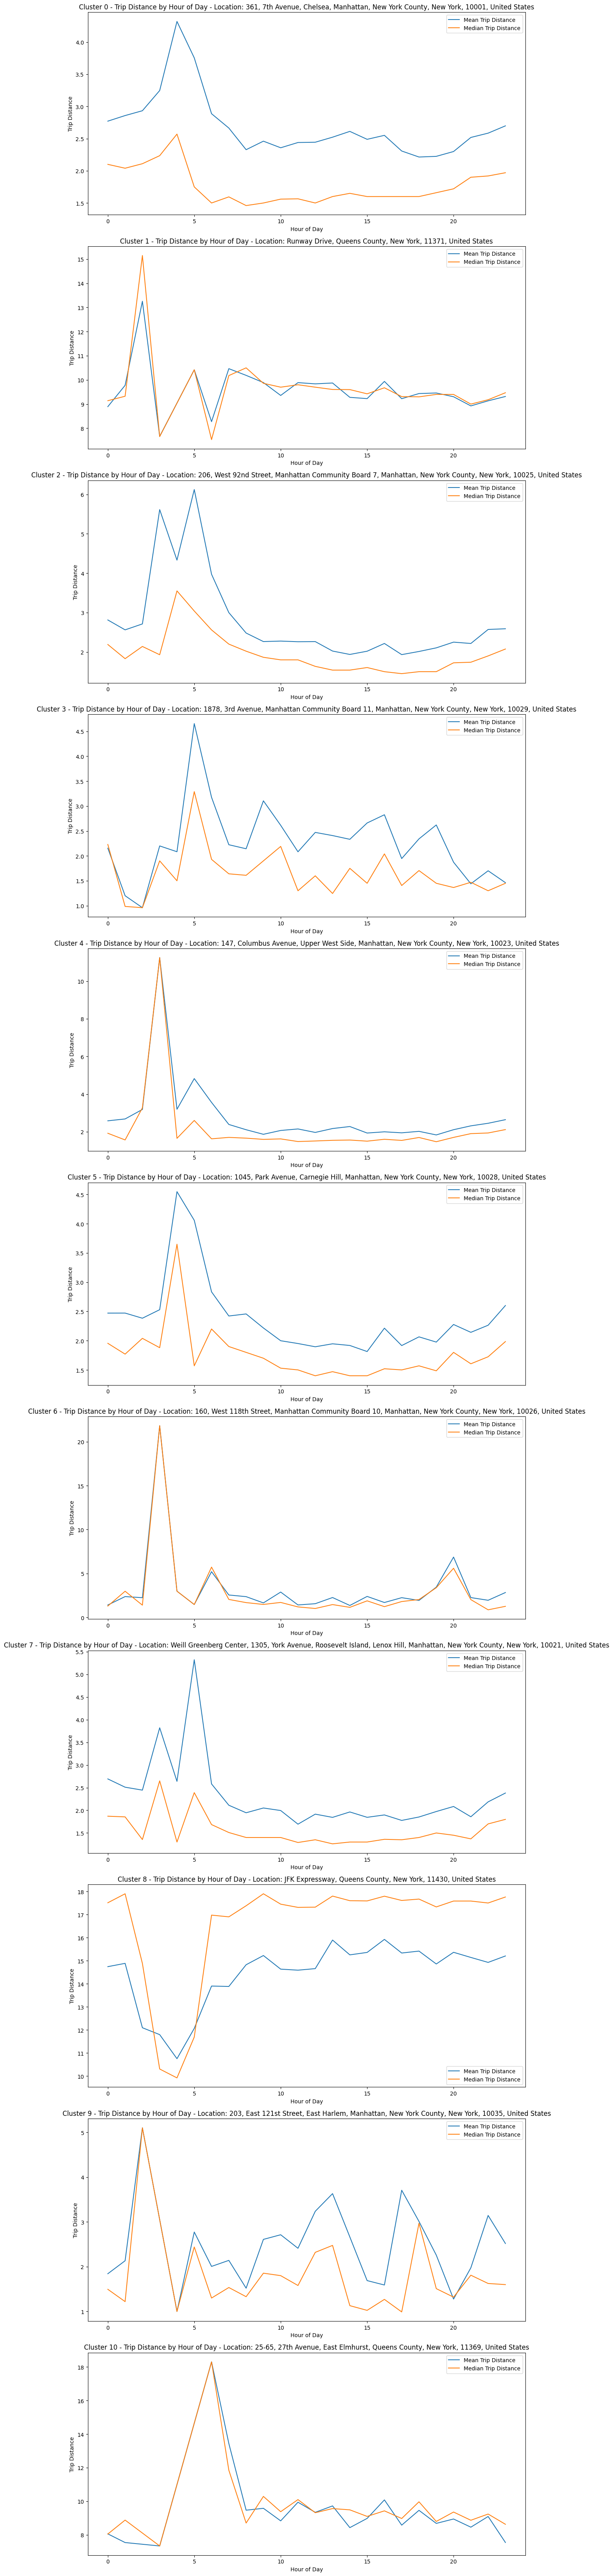

In [ ]:
data_with_coordinates['pickup_hour'] = data_with_coordinates['tpep_pickup_datetime'].dt.hour
cl_hour_groups = data_with_coordinates.groupby(['pickup_cluster', 'pickup_hour'])
cluster_hour_stats = cl_hour_groups.agg({
    'trip_distance': ['mean', 'median']
})

# Visualize the results
n_cl = len(pick_cl)
fig, axs = plt.subplots(n_cl - 1, figsize=(12, 6*(n_cl - 1)))
sub_index = 0

for i, (c, cluster_group) in enumerate(pick_cl):
    if c == -1:
        continue
    if c in pick_cl_dic:
        loc_name = pick_cl_dic[c]['location_name']

        cl_h_data = cluster_hour_stats.loc[c]
        for stat in ['mean', 'median']:
            axs[sub_index].plot(cl_h_data.index.get_level_values('pickup_hour'),
                        cl_h_data['trip_distance'][stat],
                        label=f'{stat.capitalize()} Trip Distance')
        axs[sub_index].set_xlabel('Hour of Day')
        axs[sub_index].set_ylabel('Trip Distance')
        axs[sub_index].set_title(f'Cluster {c} - Trip Distance by Hour of Day - Location: {loc_name}')
        axs[sub_index].legend()
        sub_index += 1

plt.tight_layout()
plt.show()

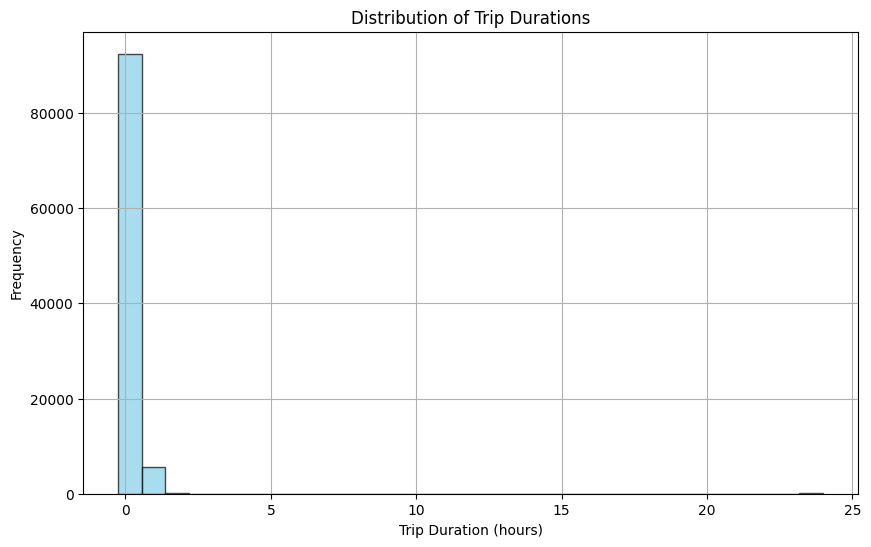

In [ ]:
data_with_coordinates['tpep_pickup_datetime'] = pd.to_datetime(data_with_coordinates['tpep_pickup_datetime'])
data_with_coordinates['tpep_dropoff_datetime'] = pd.to_datetime(data_with_coordinates['tpep_dropoff_datetime'])
# convert trip duration in hours
data_with_coordinates['trip_hours'] = (data_with_coordinates['tpep_dropoff_datetime'] - data_with_coordinates['tpep_pickup_datetime']).dt.total_seconds() / 3600
# Visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(data_with_coordinates['trip_hours'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations')
plt.grid(True)
plt.show()

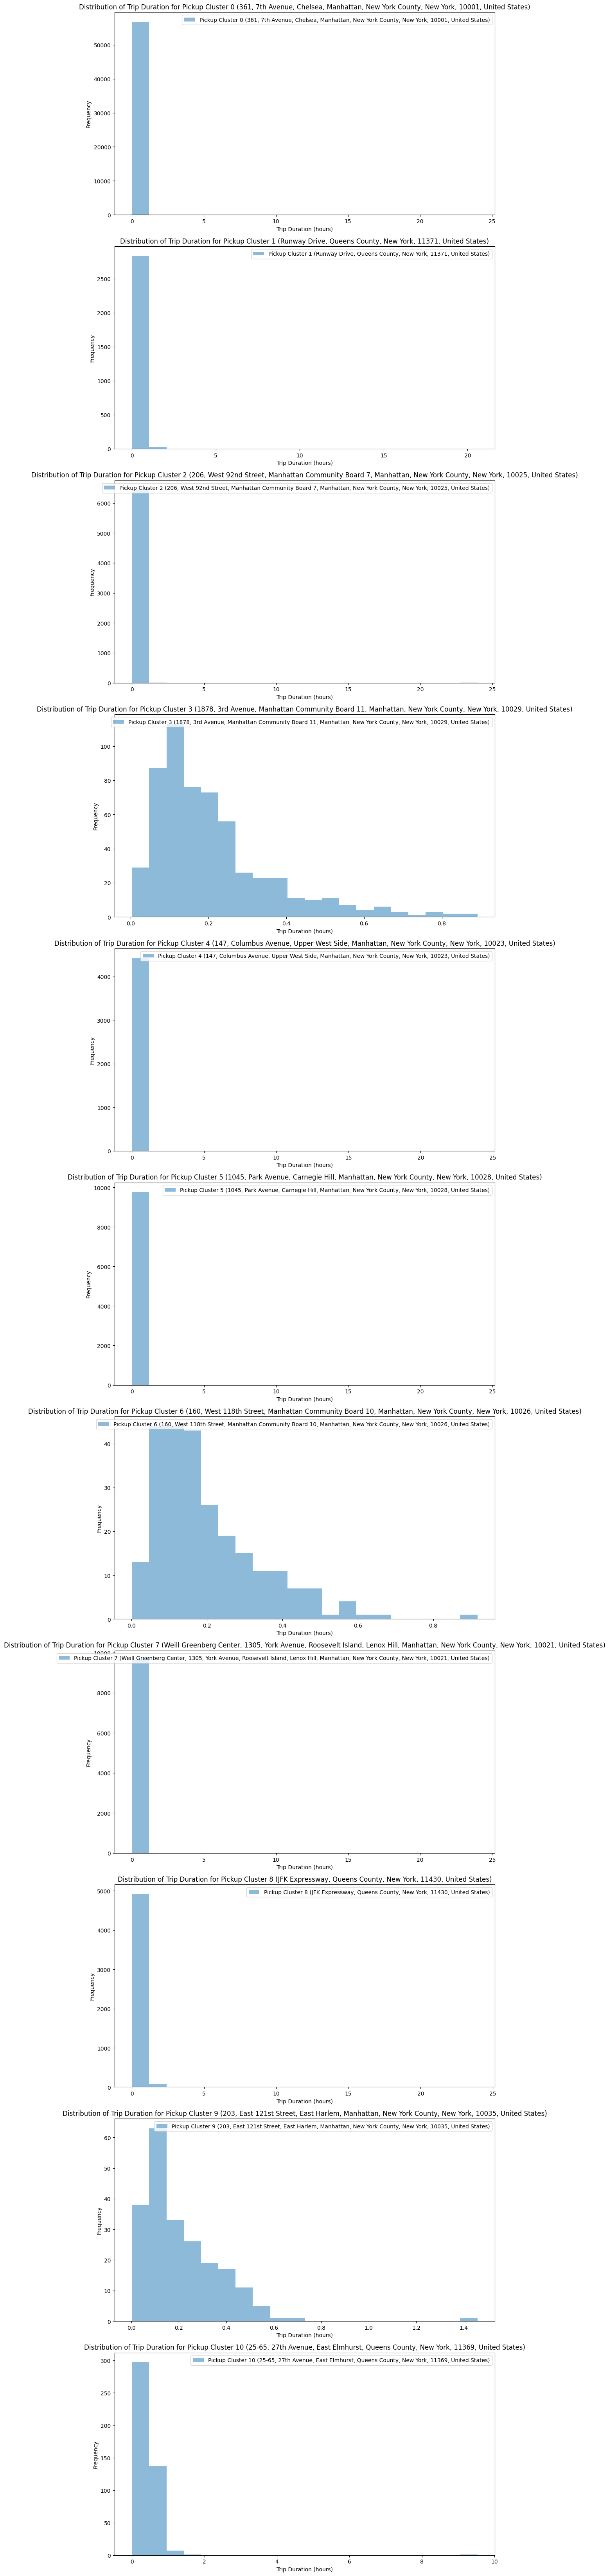

In [ ]:
# data_with_coordinates['trip_duration_hours'] = (data_with_coordinates['tpep_dropoff_datetime'] - data_with_coordinates['tpep_pickup_datetime']).dt.total_seconds() / 3600

cluster_groups = data_with_coordinates.groupby('pickup_cluster')
n_cl = len([c for c, _ in pick_cl if c != -1])
fig, axs = plt.subplots(n_cl, figsize=(12, 6*n_cl))
sub_index = 0

for c, group in pick_cl:
    if c != -1:
        loc_name = pick_cl_dic[c]['location_name']

        group['trip_hours'] = (group['tpep_dropoff_datetime'] - group['tpep_pickup_datetime']).dt.total_seconds() / 3600
        axs[sub_index].hist(group['trip_hours'], bins=20, alpha=0.5, label=f'Pickup Cluster {c} ({loc_name})')
        axs[sub_index].set_xlabel('Trip Duration (hours)')
        axs[sub_index].set_ylabel('Frequency')
        axs[sub_index].set_title(f'Distribution of Trip Duration for Pickup Cluster {c} ({loc_name})')
        axs[sub_index].legend()
        sub_index += 1

plt.tight_layout()
plt.show()


Our analysis of passenger frequency and travel time reveals that most trips last between 0 to 2 hours.

Q.2. Use the city-wise vehicle registration dataset of million+ population cities of India.

Perform K-means and Agglomerative clustering this dataset. Discuss the insights and distinguishing features of the cities belonging to the same cluster.

If you need to design a marketing campaign which cities you will target for what kind of vehicles.

Use data.gov.in to check the other kinds of datasets available that can help you with your analysis. Substantiate your results with proper facts and figures.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import parallel_coordinates
from scipy.stats import f_oneway, kruskal
from sklearn import preprocessing
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
data=pd.read_csv("/content/RTYB201920_A3_3c_0.csv")
data.head(37)

States/Union Territories  Multiaxled/Articulated Vehicles (I)  \
0                Andhra Pradesh                              10332.0   
1             Arunachal Pradesh                               1544.0   
2                         Assam                               9225.0   
3                         Bihar                              14915.0   
4                  Chhattisgarh                              38099.0   
5                           Goa                                  0.0   
6                       Gujarat                                  0.0   
7                       Haryana                             857033.0   
8              Himachal Pradesh                                  9.0   
9             Jammu and Kashmir                                498.0   
10                    Jharkhand                                 71.0   
11                    Karnataka                              19456.0   
12                       Kerala                              68871.0   
13               Madhya Pradesh                              69708.0   
14                  Maharashtra                              63880.0   
15                      Manipur                               1651.0   
16                    Meghalaya                                  0.0   
17                      Mizoram                                  2.0   
18                     Nagaland                              60697.0   
19                       Odisha                             113553.0   
20                       Punjab                                137.0   
21                    Rajasthan                                  0.0   
22                       Sikkim                                126.0   
23                   Tamil Nadu                             121720.0   
24                    Telangana                               5263.0   
25                      Tripura                                144.0   
26                  Uttarakhand                              10031.0   
27                Uttar Pradesh                             164092.0   
28                  West Bengal                                  0.0   
29  Andaman and Nicobar Islands                                  0.0   
30                   Chandigarh                                  0.0   
31                Daman and Diu                               1477.0   
32       Dadra and Nagar Haveli                                  NaN   
33                        Delhi                                  0.0   
34                  Lakshadweep                                  0.0   
35                   Puducherry                                 60.0   
36                        Total                            1632594.0   

    Trucks and Lorries (II)  \
0                  211090.0   
1                    6367.0   
2                  147374.0   
3                  126414.0   
4                  120980.0   
5                   67933.0   
6                  512530.0   
7                  294031.0   
8                   92700.0   
9                   70813.0   
10                 183988.0   
11                 485207.0   
12                 132049.0   
13                 291938.0   
14                 540172.0   
15                  15437.0   
16                  32711.0   
17                   7101.0   
18                 120788.0   
19                 128304.0   
20                 385533.0   
21                 718325.0   
22                   3721.0   
23                 483587.0   
24                 147625.0   
25                   8680.0   
26                  43413.0   
27                 251570.0   
28                      0.0   
29                      0.0   
30                   1495.0   
31                  11353.0   
32                      NaN   
33                 180923.0   
34                      0.0   
35                   2319.0   
36                5826471.0   

    Light Motor Vehicles (Goods) (II) - Four Wheelers  \
0                                 

In [ ]:
data = data[data['States/Union Territories'] != 'Total']
data = data[data['States/Union Territories'] != 'Dadra and Nagar Haveli'] # Remove due to all value is null
data = data.drop('Total Transport (I TO VII)', axis=1)
data.isnull().sum()

States/Union Territories                                        0
Multiaxled/Articulated Vehicles (I)                             0
Trucks and Lorries (II)                                         0
Light Motor Vehicles (Goods) (II) - Four Wheelers               0
Light Motor Vehicles (Goods) (II) - Three Wheelers              0
Buses (IV) - Stage carriages                                    0
Buses (IV) - Contract carriages                                 1
Buses (IV) - Private service vehicles                           1
Buses (IV) - Other buses                                        1
Taxis (V) - Motor cabs                                          0
Taxis (V) - Maxi cabs                                           1
Taxis (V) - Other taxis                                         1
Light Motor Vehicles (Passengers) (VI) - Three seaters          0
Light Motor Vehicles (Passengers) (VI) - Four to six seaters    0
Motor cycles on hire (VII)                                      0
Other vehi

In [ ]:
data.describe()
data.shape

(35, 16)

In [ ]:
data.fillna(0, inplace=True)

In [ ]:
data.isnull().sum()

States/Union Territories                                        0
Multiaxled/Articulated Vehicles (I)                             0
Trucks and Lorries (II)                                         0
Light Motor Vehicles (Goods) (II) - Four Wheelers               0
Light Motor Vehicles (Goods) (II) - Three Wheelers              0
Buses (IV) - Stage carriages                                    0
Buses (IV) - Contract carriages                                 0
Buses (IV) - Private service vehicles                           0
Buses (IV) - Other buses                                        0
Taxis (V) - Motor cabs                                          0
Taxis (V) - Maxi cabs                                           0
Taxis (V) - Other taxis                                         0
Light Motor Vehicles (Passengers) (VI) - Three seaters          0
Light Motor Vehicles (Passengers) (VI) - Four to six seaters    0
Motor cycles on hire (VII)                                      0
Other vehi

In [ ]:
data.describe()

Multiaxled/Articulated Vehicles (I)  Trucks and Lorries (II)  \
count                            35.000000                35.000000   
mean                          46645.542857            166470.600000   
std                          146802.794672            188563.329145   
min                               0.000000                 0.000000   
25%                               1.000000             10016.500000   
50%                            1477.000000            120980.000000   
75%                           28777.500000            231330.000000   
max                          857033.000000            718325.000000   

       Light Motor Vehicles (Goods) (II) - Four Wheelers  \
count                                          35.000000   
mean                                       134210.057143   
std                                        187627.209847   
min                                             0.000000   
25%                                          8892.000000   
50%                                         51754.000000   
75%                                        184922.500000   
max                                        740838.000000   

       Light Motor Vehicles (Goods) (II) - Three Wheelers  \
count                                          35.000000    
mean                                        60909.828571    
std                                        108453.314188    
min                                             0.000000    
25%                                            37.000000    
50%                                          4667.000000    
75%                                         88907.000000    
max                                        468909.000000    

       Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  \
count                     35.000000                        35.000000   
mean                   28104.628571                      9688.914286   
std                    48409.411134                     18735.618135   
min                        0.000000                         0.000000   
25%                     2123.500000                         0.000000   
50%                    14726.000000                       825.000000   
75%                    32819.000000                      7890.000000   
max                   263099.000000                     81315.000000   

       Buses (IV) - Private service vehicles  Buses (IV) - Other buses  \
count                              35.000000                 35.000000   
mean                             3821.542857               7625.571429   
std                              8209.262525              17849.955983   
min                                 0.000000                  0.000000   
25%                                 0.000000                  0.000000   
50%                                53.000000                 44.000000   
75%                              2677.500000               3889.000000   
max                             36445.000000              87785.000000   

       Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  \
count               35.000000              35.000000                35.000000   
mean             67542.771429           26767.800000              4515.628571   
std              79832.274463           57489.794484             10964.829848   
min                 85.000000               0.000000                 0.000000   
25%               8341.500000             118.000000                 0.000000   
50%              32953.000000            3081.000000                17.000000   
75%             102621.500000           28066.500000              1415.500000   
max             334484.000000          293354.000000             47933.000000   

       Light Motor Vehicles (Passengers) (VI) - Three seaters  \
count                                       3.500000e+01        
mean                                        1.716513e+05        
std                                

In [ ]:
df_data = data.copy()

In [ ]:
scaler = StandardScaler()
scale_data = scaler.fit_transform(df_data.drop('States/Union Territories', axis=1))

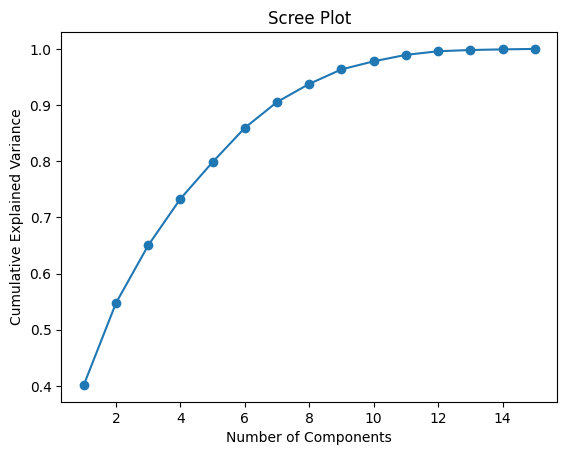

In [ ]:
# Perform PCA with various numbers of components
n_components = range(1, min(scale_data.shape[0], scale_data.shape[1]) + 1)
var = []
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(scale_data)
    var.append(sum(pca.explained_variance_ratio_))
plt.plot(n_components, var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()


In [ ]:
# Performing PCA
pca = PCA(n_components=4)
pca_data = pca.fit_transform(scale_data)

In [ ]:
# Number of cluster based on Elbow Method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i )
    kmeans.fit(pca_data)
    sse.append(kmeans.inertia_)

fig = px.line(y=sse, template="seaborn", title='Elbow Method')
fig.update_layout(width=800, height=600,
                  title_font_color="#BF40BF",
                  xaxis=dict(color="#BF40BF", title="Clusters"),
                  yaxis=dict(color="#BF40BF", title="SSE"))
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

As expected the optimal number of clusters seems to be 4 or 5 However, we’ve decided to implement the model using 5 clusters because the Silhouette score, which measures how well each data point fits within its assigned cluster, is highest when there are 5 clusters. Therefore, we’ve chosen 5 as the optimal number of clusters for our model.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)
df_data['KMeans_cluster'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
agg_cluster = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_cluster.fit_predict(pca_data)
df_data['Agglomerative_cluster'] = agg_labels

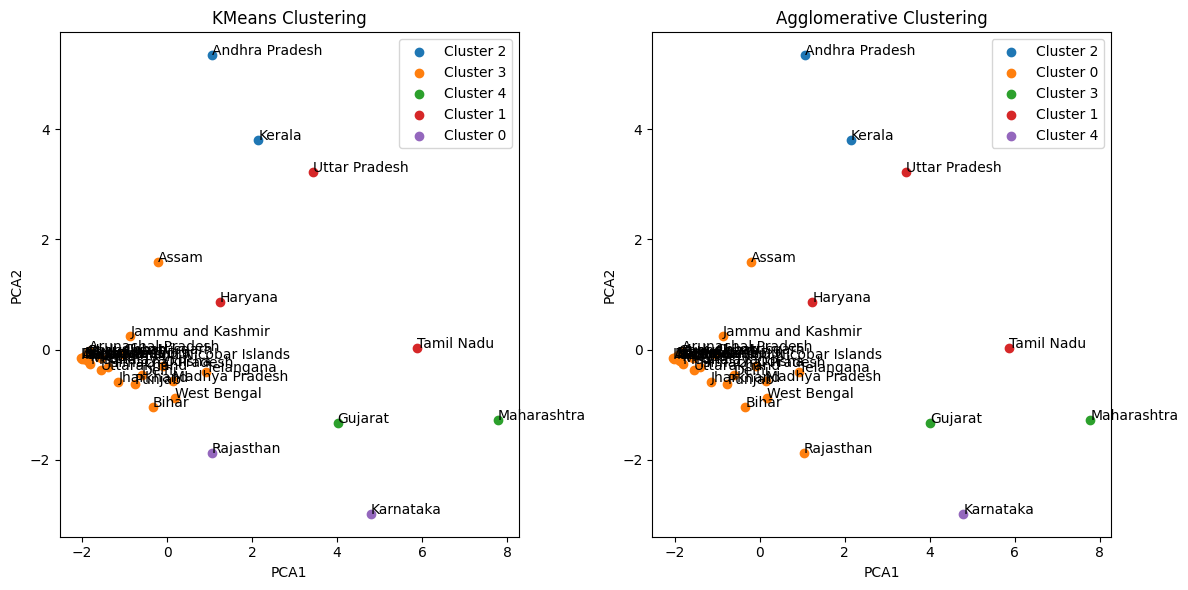

In [ ]:
plot_data = pd.DataFrame({
    'PCA1': pca_data[:, 0],
    'PCA2': pca_data[:, 1],
    'KMeans_cluster': kmeans_labels,
    'States/Union Territories': df_data['States/Union Territories']
})
plot_data_agg = pd.DataFrame({
    'PCA1': pca_data[:, 0],
    'PCA2': pca_data[:, 1],
    'Cluster': agg_labels,
    'States/Union Territories': df_data['States/Union Territories']
})

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for cluster in plot_data['KMeans_cluster'].unique():
    cluster_data = plot_data[plot_data['KMeans_cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
    for i, state in enumerate(cluster_data['States/Union Territories']):
        plt.annotate(state, (cluster_data['PCA1'].iloc[i], cluster_data['PCA2'].iloc[i]))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('KMeans Clustering')
plt.legend()

# Plotting the clusters for Agglomerative
plt.subplot(1, 2, 2)
for cluster in plot_data_agg['Cluster'].unique():
    cluster_data = plot_data_agg[plot_data_agg['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
    for i, state in enumerate(cluster_data['States/Union Territories']):
        plt.annotate(state, (cluster_data['PCA1'].iloc[i], cluster_data['PCA2'].iloc[i]))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Agglomerative Clustering')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_data.head()


States/Union Territories  Multiaxled/Articulated Vehicles (I)  \
0           Andhra Pradesh                              10332.0   
1        Arunachal Pradesh                               1544.0   
2                    Assam                               9225.0   
3                    Bihar                              14915.0   
4             Chhattisgarh                              38099.0   

   Trucks and Lorries (II)  Light Motor Vehicles (Goods) (II) - Four Wheelers  \
0                 211090.0                                           186730.0   
1                   6367.0                                             7292.0   
2                 147374.0                                           157201.0   
3                 126414.0                                            87632.0   
4                 120980.0                                            98473.0   

   Light Motor Vehicles (Goods) (II) - Three Wheelers  \
0                                            99650.0    
1                                             2566.0    
2                                            50119.0    
3                                            43021.0    
4                                            20573.0    

   Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  \
0                       20890.0                           7246.0   
1                         681.0                           6677.0   
2                        2105.0                          17029.0   
3                       43875.0                              0.0   
4                        7321.0                           1460.0   

   Buses (IV) - Private service vehicles  Buses (IV) - Other buses  \
0                                 2343.0                   28820.0   
1                                 1189.0                     733.0   
2                                    0.0                    4472.0   
3                                    0.0                       0.0   
4                                 7640.0                    3306.0   

   Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  \
0                 53568.0                26493.0                  19797.0   
1                    85.0                 1015.0                     65.0   
2                 21097.0                 9647.0                  47933.0   
3                112726.0                    0.0                      0.0   
4                 20963.0                  877.0                      0.0   

   Light Motor Vehicles (Passengers) (VI) - Three seaters  \
0                                                0.0        
1                                             7010.0        
2                                           137189.0        
3                                           399096.0        
4                                            46768.0        

   Light Motor Vehicles (Passengers) (VI) - Four to six seaters  \
0                                           619962.0              
1                                             4272.0              
2                                                0.0              
3                                                0.0              
4                                             6072.0              

   Motor cycles on hire (VII)  Other vehicles not included in (I-VII)  \
0                       703.0                                340010.0   
1                         0.0                                     0.0   
2                         0.0                                     0.0   
3                         0.0                                     0.0   
4                         0.0                                     0.0   

   KMeans_cluster  Agglomerative_cluster  
0               2                      2  
1               3                      0  
2               3                      0  
3               3                      0  
4               3                      0

In [ ]:
# Silhouette score for KMeans
s_kmeans = silhouette_score(pca_data, kmeans_labels)
print(f"Silhouette Score for KMeans: {s_kmeans}")
# Silhouette score for Agglomerative clustering
s_agg = silhouette_score(pca_data, agg_labels)
print(f"Silhouette Score for Agglomerative Clustering: {s_agg}")


Silhouette Score for KMeans: 0.6350950889446845
Silhouette Score for Agglomerative Clustering: 0.6321903148105028


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 2, the average silhouette score is : 0.5968465055993851
For n_clusters = 3, the average silhouette score is : 0.5969036125869475
For n_clusters = 4, the average silhouette score is : 0.6327498057153672
For n_clusters = 5, the average silhouette score is : 0.6350950889446845
For n_clusters = 6, the average silhouette score is : 0.4747355919987211


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 7, the average silhouette score is : 0.46289299039452825


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 8, the average silhouette score is : 0.45572794021438157
For n_clusters = 9, the average silhouette score is : 0.44996272000484927


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 10, the average silhouette score is : 0.4407116980588559


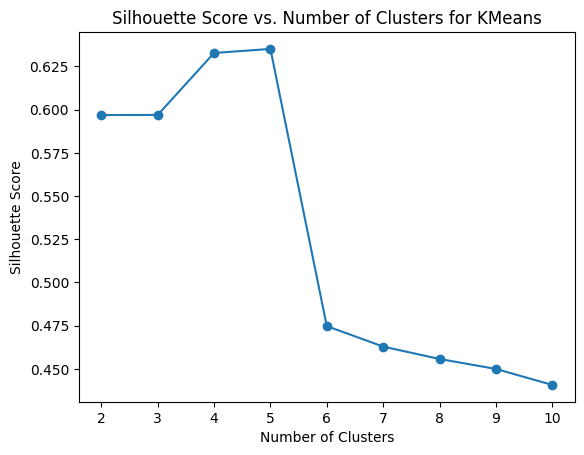

In [ ]:
# List to store silhouette scores for different numbers of clusters
silhouette_scores = []
for n_cl in range(2, 11):
    kmeans = KMeans(n_clusters=n_cl, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    silhouette_avg = silhouette_score(pca_data, kmeans_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_cl}, the average silhouette score is : {silhouette_avg}")
import matplotlib.pyplot as plt

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for KMeans')
plt.show()


For n_clusters = 2, the average silhouette score is : 0.5880698382409688
For n_clusters = 3, the average silhouette score is : 0.6195585912178311
For n_clusters = 4, the average silhouette score is : 0.6327498057153672
For n_clusters = 5, the average silhouette score is : 0.6321903148105028
For n_clusters = 6, the average silhouette score is : 0.4694725649618817
For n_clusters = 7, the average silhouette score is : 0.4572861317064199
For n_clusters = 8, the average silhouette score is : 0.4501210815262733
For n_clusters = 9, the average silhouette score is : 0.46788988858795344
For n_clusters = 10, the average silhouette score is : 0.45925865218003525


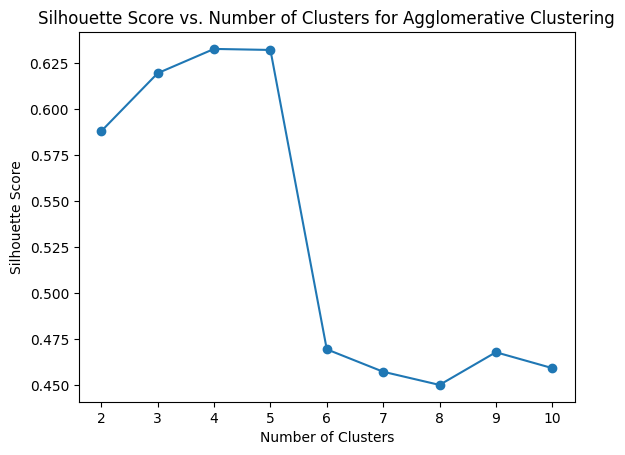

In [ ]:
# List to store silhouette scores for different numbers of clusters
silhouette_scores_agg = []
for n_clusters in range(2, 11):
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_cluster.fit_predict(pca_data)
    silhouette_avg_agg = silhouette_score(pca_data, agg_labels)
    silhouette_scores_agg.append(silhouette_avg_agg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg_agg}")

plt.plot(range(2, 11), silhouette_scores_agg, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for Agglomerative Clustering')
plt.show()


In [ ]:
# KMeans_cluster
cluster_features_kmeans = df_data.drop('Agglomerative_cluster', axis=1).groupby('KMeans_cluster').mean()
print(cluster_features_kmeans.to_string())

                Multiaxled/Articulated Vehicles (I)  Trucks and Lorries (II)  Light Motor Vehicles (Goods) (II) - Four Wheelers  Light Motor Vehicles (Goods) (II) - Three Wheelers  Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  Buses (IV) - Private service vehicles  Buses (IV) - Other buses  Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  Light Motor Vehicles (Passengers) (VI) - Three seaters  Light Motor Vehicles (Passengers) (VI) - Four to six seaters  Motor cycles on hire (VII)  Other vehicles not included in (I-VII)
KMeans_cluster                                                                                                                                                                                                                                                                                                                                                                                                                                    

<ipython-input-54-da2ee4acd635>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



KMeans_cluster

1. Rajasthan and Karnataka has a high mean value for ‘Trucks and Lorries (II)’, ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’, and ‘Light Motor Vehicles (Passengers) (VI) - Three seaters’. This suggests that these states have a high demand for goods transportation and passenger vehicles. Businesses in the logistics, e-commerce, and public transportation sectors may find good opportunities in these states.
2. Haryana, Tamil Nadu, Uttar Pradesh are the states show high mean values for ‘Multiaxled/Articulated Vehicles (I)’, ‘Trucks and Lorries (II)’, and ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’. This indicates a strong presence of heavy vehicles, likely used for industrial and agricultural purposes. Industries related to manufacturing, agriculture, and heavy goods transportation might thrive in these states.
3. Kerala and Andhra Pradesh are the states have a high mean value for ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’ and ‘Other vehicles not included in (I-VII)’. This indicates a diverse mix of vehicle types, suggesting a balanced demand for both passenger and goods transportation. Diverse businesses from various sectors can potentially succeed in these states.
4. Gujarat and Maharashtra states have high mean values for ‘Trucks and Lorries (II)’, ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’, ‘Buses (IV) - Other buses’, and ‘Light Motor Vehicles (Passengers) (VI) - Three seaters’. This cluster seems to have a diverse mix of vehicle types, indicating a robust transportation network supporting various industries. These states, being industrial and commercial hubs of India, present ample business opportunities across sectors.
5.Others states have relatively low mean values for all vehicle types compared to other clusters. This could suggest lower overall vehicle counts, possibly due to lower population density or less industrial activity. Businesses in these states might focus on improving transportation infrastructure or explore opportunities in untapped markets.

In [ ]:
# Agglomerative_cluster
cluster_features_agglomerative = df_data.drop('KMeans_cluster', axis=1).groupby('Agglomerative_cluster').mean()
print(cluster_features_agglomerative.to_string())

                       Multiaxled/Articulated Vehicles (I)  Trucks and Lorries (II)  Light Motor Vehicles (Goods) (II) - Four Wheelers  Light Motor Vehicles (Goods) (II) - Three Wheelers  Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  Buses (IV) - Private service vehicles  Buses (IV) - Other buses  Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  Light Motor Vehicles (Passengers) (VI) - Three seaters  Light Motor Vehicles (Passengers) (VI) - Four to six seaters  Motor cycles on hire (VII)  Other vehicles not included in (I-VII)
Agglomerative_cluster                                                                                                                                                                                                                                                                                                                                                                                                                      

<ipython-input-55-3dd8721985dc>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.





1. Gujarat and Maharashtra states have high mean values for ‘Trucks and Lorries (II)’, ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’, ‘Buses (IV) - Other buses’, and ‘Light Motor Vehicles (Passengers) (VI) - Three seaters’. This cluster seems to have a diverse mix of vehicle types, indicating a robust transportation network supporting various industries. These states, being industrial and commercial hubs of India, present ample business opportunities across sectors.
2. Karnataka has a high mean value for ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’ and ‘Taxis (V) - Motor cabs’. This suggests that these states have a high demand for goods transportation and taxi services. Businesses in the logistics, e-commerce, and taxi service sectors may find good opportunities in these states.
3. Haryana, Tamil Nadu, Uttar Pradesh states show high mean values for ‘Multiaxled/Articulated Vehicles (I)’, ‘Trucks and Lorries (II)’, and ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’. This indicates a strong presence of heavy vehicles, likely used for industrial and agricultural purposes. Industries related to manufacturing, agriculture, and heavy goods transportation might thrive in these states.
4. Kerala and Andhra Pradesh states have a high mean value for ‘Light Motor Vehicles (Goods) (II) - Four Wheelers’ and ‘Other vehicles not included in (I-VII)’. This indicates a diverse mix of vehicle types, suggesting a balanced demand for both passenger and goods transportation. Diverse businesses from various sectors can potentially succeed in these states.
5.Others states have relatively low mean values for all vehicle types compared to other clusters. This could suggest lower overall vehicle counts, possibly due to lower population density or less industrial activity. Businesses in these states might focus on improving transportation infrastructure or explore opportunities in untapped markets.

Marketing Strategies

Based on the clustering results, here are some potential marketing strategies for different types of vehicles:

1. Big Trucks and Lorries: These vehicles are mostly used in Haryana, Tamil
   Nadu, and Uttar Pradesh. So, if we are selling these types of vehicles, we could focus our marketing efforts in these states. We could highlight features like durability, load capacity, and fuel efficiency in our advertisements.
2. Small Trucks and Four-Wheelers for Goods: These vehicles are used all  over
   the country, but especially in Rajasthan, Karnataka, Kerala, Andhra Pradesh, Gujarat, and Maharashtra. If we are selling these vehicles, we could target small businesses that need to transport goods locally. We could emphasize features like fuel efficiency, cargo space, and low maintenance costs in our marketing materials.
3. Buses: Buses are mostly used in Gujarat and Maharashtra. If we are selling
   buses, we could target public transportation departments and private travel companies in these states. We could highlight features like passenger comfort, safety, and fuel efficiency in our advertisements.
4. Taxis: Taxis are mostly used in Gujarat and Maharashtra. If we are selling
   taxis, we could target taxi service companies and independent taxi operators in these states. We could emphasize features like passenger comfort, fuel efficiency, and low maintenance costs in our marketing materials.
5. Small Cars for Personal Use: These vehicles are mostly used in Rajasthan and
   Karnataka. If we are selling these vehicles, we could target families and individuals in these states. We could highlight features like fuel efficiency, safety, comfort, and stylish design in our advertisements.
6. Motorcycles for Hire: These vehicles are not as common as the others, but
   they are used in some places. If we are selling these vehicles, we could target delivery services or bike rental companies, especially in tourist areas. We could emphasize features like fuel efficiency, ease of parking, and low maintenance costs in our marketing materials.



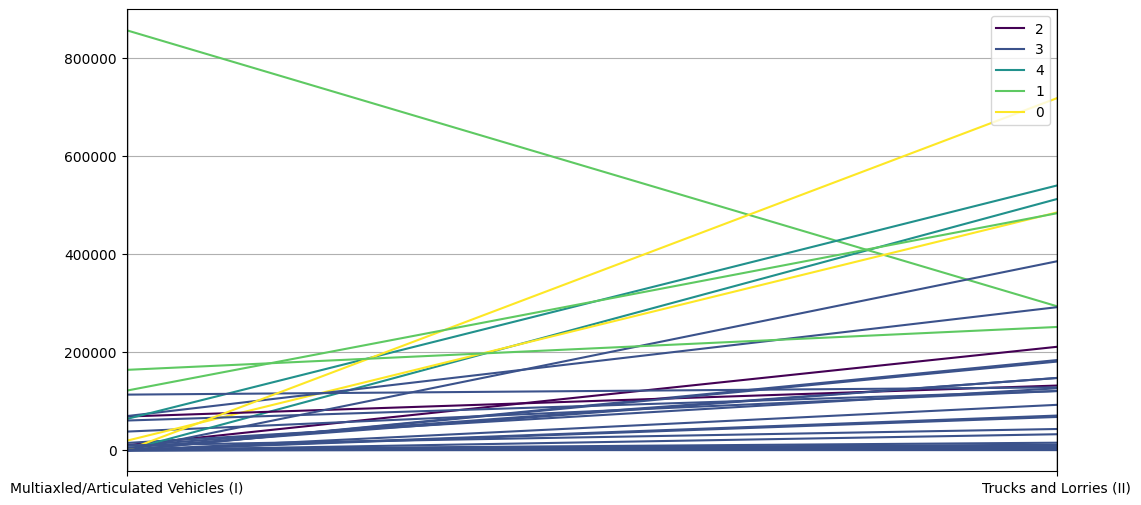

In [ ]:
# Multiaxled/Articulated Vehicles (I) and KMeans_cluster
cols_to_plot = ['Multiaxled/Articulated Vehicles (I)', 'Trucks and Lorries (II)', 'KMeans_cluster']
plt.figure(figsize=(12,6))
parallel_coordinates(df_data[cols_to_plot], 'KMeans_cluster', colormap='viridis')
plt.show()


In [ ]:
# KMeans cluster
kmeans_counts = df_data['KMeans_cluster'].value_counts()
print("KMeans Clustering:")
print(kmeans_counts)
# Agglomerative cluster
agglomerative_counts = df_data['Agglomerative_cluster'].value_counts()
print("\nAgglomerative Clustering:")
print(agglomerative_counts)


KMeans Clustering:
3    26
1     3
2     2
4     2
0     2
Name: KMeans_cluster, dtype: int64

Agglomerative Clustering:
0    27
1     3
2     2
3     2
4     1
Name: Agglomerative_cluster, dtype: int64


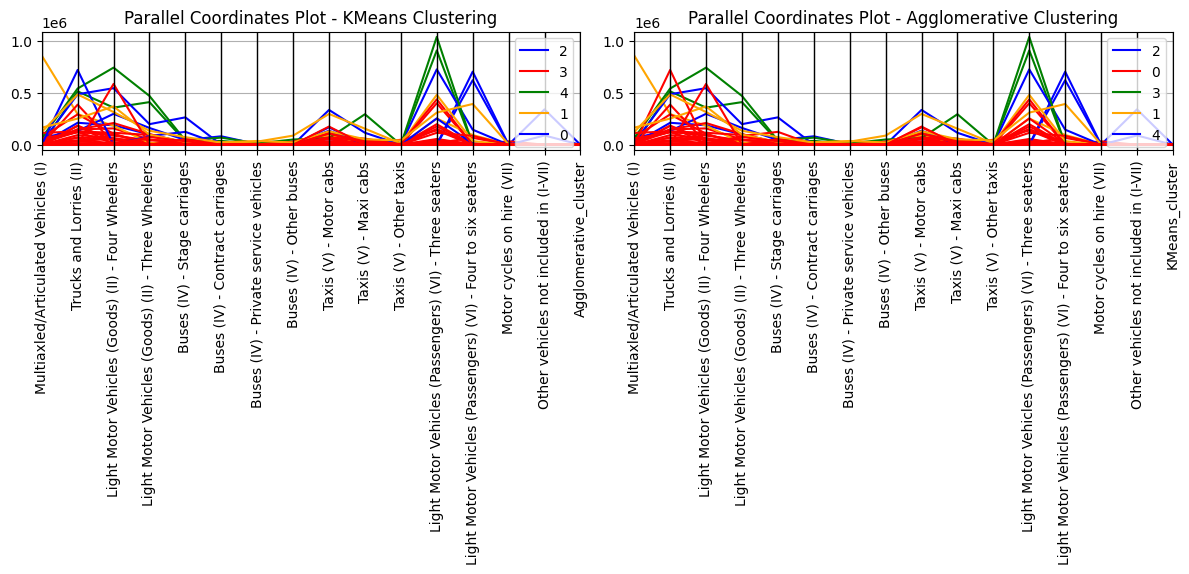

In [ ]:
# Plotting Parallel Coordinates Plot for KMeans
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
pd.plotting.parallel_coordinates(df_data.drop('States/Union Territories', axis=1), 'KMeans_cluster', color=('blue', 'red', 'green', 'orange'))
plt.title('Parallel Coordinates Plot - KMeans Clustering')
plt.xticks(rotation=90)
# Plotting Parallel Coordinates Plot for Agglomerative
plt.subplot(1, 2, 2)
pd.plotting.parallel_coordinates(df_data.drop('States/Union Territories', axis=1), 'Agglomerative_cluster', color=('blue', 'red', 'green', 'orange'))
plt.title('Parallel Coordinates Plot - Agglomerative Clustering')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
cl_label_col = 'KMeans_cluster'
num_col = df_data.select_dtypes(include=['number']).columns
anova_results = []
kruskal_results = []

for f in num_col:
    group_data = df_data.groupby(cl_label_col)[f]
    anova_stat, anova_p_value = f_oneway(*[group for name, group in group_data])
    anova_results.append({'Feature': f, 'ANOVA Statistic': anova_stat, 'ANOVA p-value': anova_p_value})
    kruskal_stat, kruskal_p_value = kruskal(*[group for name, group in group_data])
    kruskal_results.append({'Feature': f, 'Kruskal-Wallis Statistic': kruskal_stat, 'Kruskal-Wallis p-value': kruskal_p_value})
anova_df = pd.DataFrame(anova_results)
kruskal_df = pd.DataFrame(kruskal_results)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [ ]:
anova_df.head()

Feature  ANOVA Statistic  \
0                Multiaxled/Articulated Vehicles (I)         7.595912   
1                            Trucks and Lorries (II)        22.447133   
2  Light Motor Vehicles (Goods) (II) - Four Wheelers         7.498394   
3  Light Motor Vehicles (Goods) (II) - Three Whee...        65.205110   
4                       Buses (IV) - Stage carriages        24.783435   

   ANOVA p-value  
0   2.370693e-04  
1   1.170824e-08  
2   2.597918e-04  
3   2.303523e-14  
4   3.878484e-09

In [ ]:
kruskal_df.head()

Feature  \
0                Multiaxled/Articulated Vehicles (I)   
1                            Trucks and Lorries (II)   
2  Light Motor Vehicles (Goods) (II) - Four Wheelers   
3  Light Motor Vehicles (Goods) (II) - Three Whee...   
4                       Buses (IV) - Stage carriages   

   Kruskal-Wallis Statistic  Kruskal-Wallis p-value  
0                 10.445891                0.033551  
1                 17.311163                0.001682  
2                 12.365896                0.014828  
3                 17.067682                0.001875  
4                 12.608303                0.013357

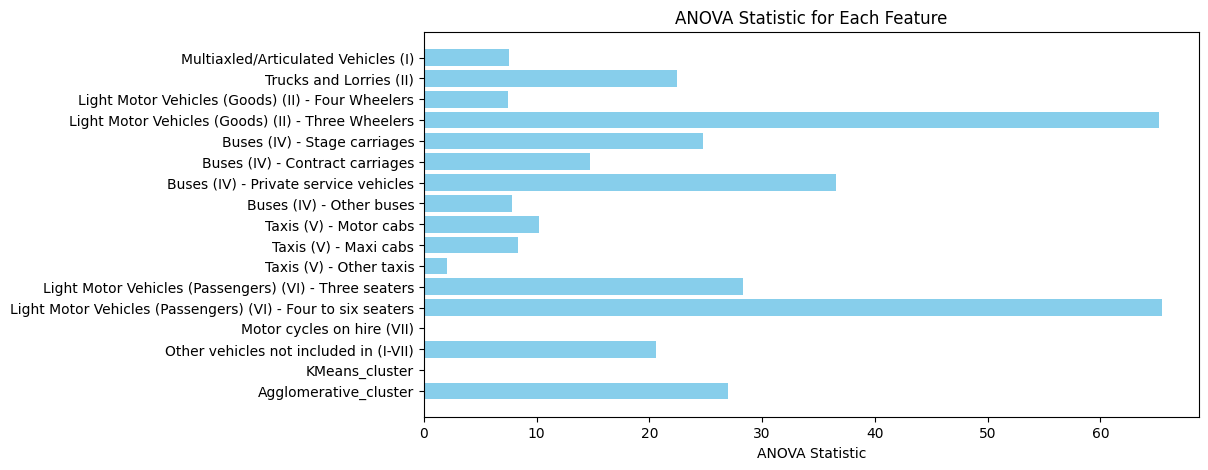

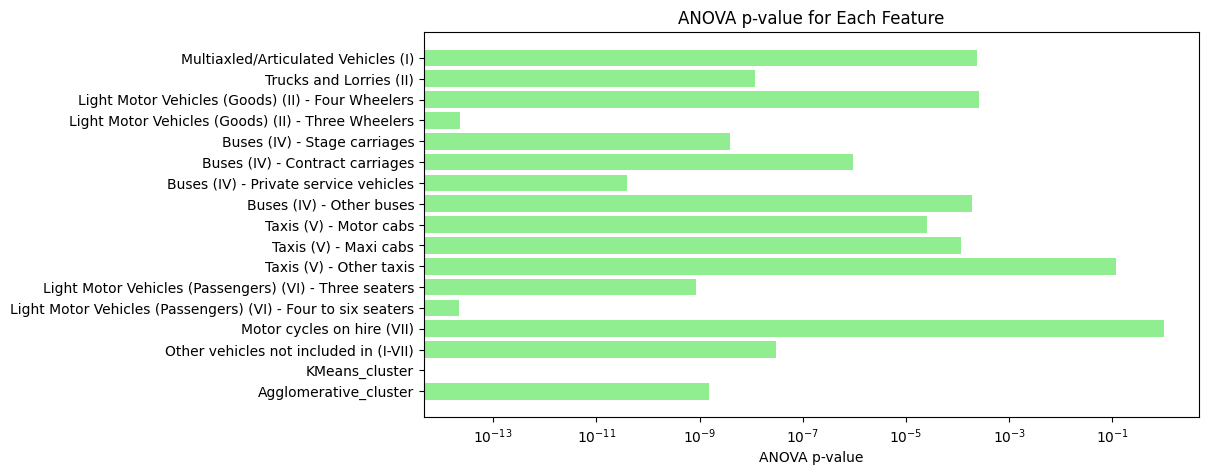

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(anova_df['Feature'], anova_df['ANOVA Statistic'], color='skyblue')
plt.xlabel('ANOVA Statistic')
plt.title('ANOVA Statistic for Each Feature')
plt.gca().invert_yaxis()
plt.show()
plt.figure(figsize=(10, 5))
plt.barh(anova_df['Feature'], anova_df['ANOVA p-value'], color='lightgreen')
plt.xlabel('ANOVA p-value')
plt.title('ANOVA p-value for Each Feature')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.show()


In [ ]:
# using dataset of Indian_cities
p_data=pd.read_csv("/content/indian_cities.csv")
cluster_features = df_data.groupby('KMeans_cluster').mean(numeric_only=True)
city_features = p_data.groupby('State').mean(numeric_only=True)
merged_data = pd.merge(df_data, city_features,  left_on='States/Union Territories', right_on='State')
m_data=merged_data[["States/Union Territories","Population","KMeans_cluster","Agglomerative_cluster"]]
m_data.head()

States/Union Territories     Population  KMeans_cluster  \
0           Andhra Pradesh  430108.000000               2   
1                    Assam  346867.250000               3   
2                    Bihar  259047.653846               3   
3             Chhattisgarh  348612.333333               3   
4                  Gujarat  598813.300000               4   

   Agglomerative_cluster  
0                      2  
1                      0  
2                      0  
3                      0  
4                      3

The clustering results from KMeans and Agglomerative clustering might differ due to the algorithms' inherent differences and the choice of parameters.
States with similar population characteristics are grouped together in the same clusters, implying some level of homogeneity within those clusters.

1. Manufacturing and Construction: The high usage of heavy vehicles like trucks
   and lorries in states like Haryana, Tamil Nadu, and Uttar Pradesh suggests a strong manufacturing and construction sector. These industries could see growth due to the demand for transportation of goods and materials.
2. Retail and E-commerce: The widespread use of light motor vehicles for goods
   across many states indicates a strong retail sector. This could also suggest a thriving e-commerce industry, as these vehicles are often used for local delivery of goods.
3. Public Transportation: The prominence of buses in Gujarat and Maharashtra
   suggests a well-developed public transportation system. This could impact the urban development and real estate industries, as well as tourism.
4. Taxi Services and Ride-Hailing: The high usage of taxis in Gujarat and   
   Maharashtra could indicate a strong demand for personal transportation services. This could impact the growth of taxi services and ride-hailing apps in these states.
5. Automobile Industry: The demand for different types of vehicles across all
   states could impact the automobile industry. Car manufacturers and dealerships could see growth in these regions.
6. Tourism: The use of motorcycles for hire in some areas suggests these might
   be tourist spots. This could impact the local tourism industry, including hotels, restaurants, and travel agencies.
7. Infrastructure Development: States with lower vehicle counts might require
   improved transportation infrastructure. This could impact industries related to road construction and maintenance.

--------------------------------------------------------------------------------

Q.3. Use Spotify dataset for Association rule mining.

Identify user playlist patterns based on features like Artist name, Playlist name etc.

Find association rules based on frequently played artists/playlists. Determine which of them classify as strong.

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10MBLIRFAzDot71ikvtLePbPahbiT6xK-
From (redirected): https://drive.google.com/uc?id=10MBLIRFAzDot71ikvtLePbPahbiT6xK-&confirm=t&uuid=4477cece-f93d-45c2-a962-b39e30f16968
To: /content/spotify_dataset.csv
100% 1.18G/1.18G [00:16<00:00, 70.6MB/s]


In [ ]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/spotify_dataset.csv",nrows=1000000 ,usecols=[0, 1, 2, 3])

# Change column names
df.columns = ['user_id', 'artistname', 'trackname', 'playlistname']

/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [ ]:
df.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user_id   artistname trackname playlistname
count                            1000000       997903    999991       999930
unique                              1497        66372    374641        17735
top     61baddf7207fea410abdc56e680fa869  Johnny Cash     Intro      Starred
freq                               18901         3424       528        92140

In [ ]:
df=df.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove duplicates
df = df.drop_duplicates()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove special characters from all columns
for col in df.columns:
    df[col] = df[col].str.replace('[^\w\s]', '', regex=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence '\w'
<>:3: DeprecationWarning: invalid escape sequence '\w'
<ipython-input-4-f45d82f6ab76>:3: DeprecationWarning: invalid escape sequence '\w'
  df[col] = df[col].str.replace('[^\w\s]', '', regex=True)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user_id                       artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                   Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello  The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                     Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello  The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                   Elvis Costello   

                                          trackname    playlistname  
0                The Angels Wanna Wear My Red Shoes  HARD ROCK 2010  
1  Whats So Funny Bout Peace Love And Understanding  HARD ROCK 2010  
2                                  7 Years Too Late  HARD ROCK 2010  
3                             Accidents Will Happen  HARD ROCK 2010  
4                                            Alison  HARD ROCK 2010

In [ ]:
df.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user_id   artistname trackname playlistname
count                             997809       997809    997809       997809
unique                              1497        66127    368728        17270
top     61baddf7207fea410abdc56e680fa869  Johnny Cash     Intro      Starred
freq                               18899         3424       531        92013

In [ ]:
plays_user = pd.DataFrame(
    df.user_id.value_counts()
).reset_index().rename(columns={'index':'user_id',
                                'user_id':'total_plays'})
plays_user.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user_id  total_plays
0  61baddf7207fea410abdc56e680fa869        18899
1  280b75289c00a3b31c9a392ea96e79f8        13027
2  8e15cf066b0218e0613c6277bdbff5f2        11228
3  db937456654d2465292c4daa947c95de        10777
4  c50566d83fba17b20697039d5824db78        10763

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



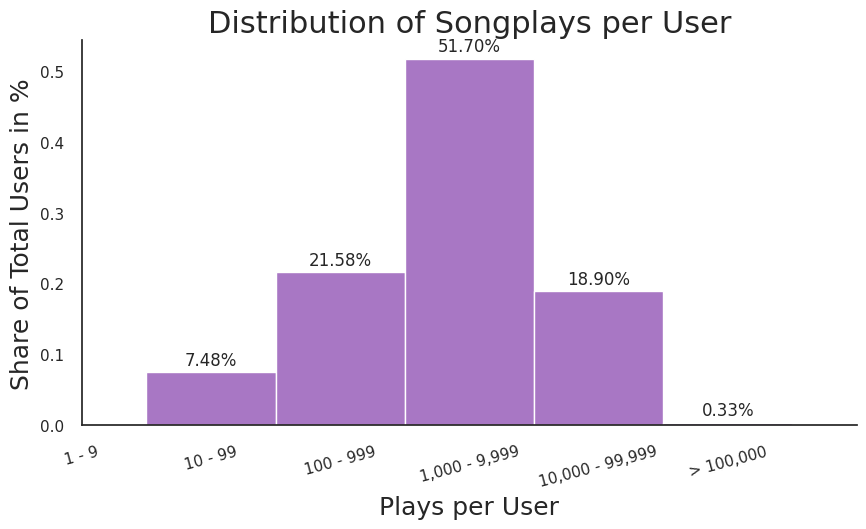

In [ ]:
plot_df = plays_user.copy()
plot_df['log_bin'] = plot_df.total_plays.apply(lambda x: int(np.log10(x))) + 1

# Names for the bins on x-axis
bin_names = ["1 - 9", "10 - 99", "100 - 999", "1,000 - 9,999", "10,000 - 99,999", "> 100,000",""]

sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(10,5))

sns.histplot(data=plot_df,
             x="log_bin",
             color='#8b4ab0',
             stat="probability",
             discrete=True
            )

sns.despine()
sns.set(font_scale = 1)
ax.set_xticks(ax.get_xticks().tolist())
ax.set_xticklabels(bin_names, rotation=15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

ax.set_title('Distribution of Songplays per User', fontsize=22)
ax.set_xlabel('Plays per User', fontsize=18)
ax.set_ylabel('Share of Total Users in %', fontsize=18)
_ = ax.legend([],[], frameon=False)


It appears that our dataset comprises highly engaged users. Over half of the listeners have shared their Spotify songplays, ranging from 1000 to 9999 times.

This is advantageous for us, as the increased data per user enhances our ability to categorize them based on their musical preferences.

In [ ]:
plays_user.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user_id  total_plays
0  61baddf7207fea410abdc56e680fa869        18899
1  280b75289c00a3b31c9a392ea96e79f8        13027
2  8e15cf066b0218e0613c6277bdbff5f2        11228
3  db937456654d2465292c4daa947c95de        10777
4  c50566d83fba17b20697039d5824db78        10763

For Total Dataset all records It seems that one user has posted close to 295,292 songplays

This number is quite staggering…

If we consider an average song length of 2.5 minutes, this would equate to over 512 days of continuous music listening.

This user could be an avid music enthusiast, or perhaps it’s a corporate marketing account, or even spam.

In [ ]:
# Top Song
top_song = (df
            .groupby(['artistname'])
            .agg({'user_id':['count', 'nunique']})
            .sort_values(('user_id','count'), ascending=False)
           )
top_song.columns = ['plays','listeners']
top_song.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



plays  listeners
artistname                          
Johnny Cash          3424        207
Coldplay             3146        431
Daft Punk            3086        401
The Rolling Stones   2920        254
JAY Z                2580        358
Radiohead            2505        283
Arctic Monkeys       2498        277
Kanye West           2281        329
Muse                 2203        269
Queen                2197        291

In [ ]:
# Top Artists
# Top 10 artists listened to by user with most songplays
top_artists = pd.DataFrame(df.artistname.value_counts()).reset_index()
top_artists.columns = ['artistname', 'plays']
print("Number of Artists:")
print(f'{len(top_artists):,}')
print()

print("Most played Artist:")
print("{0} - {1} plays".format(top_artists.loc[0, 'artistname'], f'{top_artists.loc[0, "plays"]:,}'))
print()

Number of Artists:
66,127

Most played Artist:
Johnny Cash - 3,424 plays



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user_id                       artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                   Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello  The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                     Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello  The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                   Elvis Costello   

                                          trackname    playlistname  
0                The Angels Wanna Wear My Red Shoes  HARD ROCK 2010  
1  Whats So Funny Bout Peace Love And Understanding  HARD ROCK 2010  
2                                  7 Years Too Late  HARD ROCK 2010  
3                             Accidents Will Happen  HARD ROCK 2010  
4                                            Alison  HARD ROCK 2010

In [ ]:
basket=(df.groupby(['user_id','artistname'])['playlistname']
        .count().unstack().reset_index().fillna(0)
        .set_index('user_id'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
basket.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



artistname                               The Mysterians   And the Mysterians  \
user_id                                                                        
00152c870313100559aad7b097d9c1f5  0.0               0.0                  0.0   
001c4e5b73eca68ee9756bb0c7d2f855  0.0               0.0                  0.0   
00d93ed490e116f5d3f2c4ea5703d8e9  0.0               0.0                  0.0   
00f38a9f7e21c349643b32489bda6ff3  0.0               0.0                  0.0   
0121dbf0261e4015078c312f7dd5996d  0.0               0.0                  0.0   

artistname                         Comfort   Crosses   Dolce   More  \
user_id                                                               
00152c870313100559aad7b097d9c1f5       0.0       0.0     0.0    0.0   
001c4e5b73eca68ee9756bb0c7d2f855       0.0       0.0     0.0    0.0   
00d93ed490e116f5d3f2c4ea5703d8e9       0.0       0.0     0.0    0.0   
00f38a9f7e21c349643b32489bda6ff3       0.0       0.0     0.0    0.0   
0121dbf0261e4015078c312f7dd5996d       0.0       0.0     0.0    0.0   

artistname                        007 Collective  009 Sound System   01  ...  \
user_id                                                                  ...   
00152c870313100559aad7b097d9c1f5             0.0               0.0  0.0  ...   
001c4e5b73eca68ee9756bb0c7d2f855             0.0               0.0  0.0  ...   
00d93ed490e116f5d3f2c4ea5703d8e9             0.0               0.0  0.0  ...   
00f38a9f7e21c349643b32489bda6ff3             0.0               0.0  0.0  ...   
0121dbf0261e4015078c312f7dd5996d             0.0               0.0  0.0  ...   

artistname                        蕭雅軒  陳奕迅  鷺巣詩郎  黃美珍   黑豹  \
user_id                                                      
00152c870313100559aad7b097d9c1f5  0.0  0.0   0.0  0.0  0.0   
001c4e5b73eca68ee9756bb0c7d2f855  0.0  0.0   0.0  0.0  0.0   
00d93ed490e116f5d3f2c4ea5703d8e9  0.0  0.0   0.0  0.0  0.0   
00f38a9f7e21c349643b32489bda6ff3  0.0  0.0   0.0  0.0  0.0   
0121dbf0261e4015078c312f7dd5996d  0.0  0.0   0.0  0.0  0.0   

artistname                        소녀시대 Girls Generation  슈퍼주니어   싸이  싸이Psy  \
user_id                                                                      
00152c870313100559aad7b097d9c1f5                    0.0    0.0  0.0    0.0   
001c4e5b73eca68ee9756bb0c7d2f855                    0.0    0.0  0.0    0.0   
00d93ed490e116f5d3f2c4ea5703d8e9                    0.0    0.0  0.0    0.0   
00f38a9f7e21c349643b32489bda6ff3                    0.0    0.0  0.0    0.0   
0121dbf0261e4015078c312f7dd5996d                    0.0    0.0  0.0    0.0   

artistname                        장기하와 얼굴들 Kiha  The Faces  
user_id                                                     
00152c870313100559aad7b097d9c1f5                       0.0  
001c4e5b73eca68ee9756bb0c7d2f855                       0.0  
00d93ed490e116f5d3f2c4ea5703d8e9                       0.0  
00f38a9f7e21c349643b32489bda6ff3                       0.0  
0121dbf0261e4015078c312f7dd5996d                       0.0  

[5 rows x 66127 columns]

In [ ]:
if basket.columns.duplicated().any():
    print("Not all column names are unique.")
else:
    print("All column names are unique.")

All column names are unique.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def encode_units(x):
  if x<=0:
    return 0
  if x>=1:
    return 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
basketr_sets=basket.applymap(encode_units)

In [ ]:
basketr_sets.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



artistname                             The Mysterians   And the Mysterians  \
user_id                                                                      
00152c870313100559aad7b097d9c1f5  0                 0                    0   
001c4e5b73eca68ee9756bb0c7d2f855  0                 0                    0   
00d93ed490e116f5d3f2c4ea5703d8e9  0                 0                    0   
00f38a9f7e21c349643b32489bda6ff3  0                 0                    0   
0121dbf0261e4015078c312f7dd5996d  0                 0                    0   

artistname                         Comfort   Crosses   Dolce   More  \
user_id                                                               
00152c870313100559aad7b097d9c1f5         0         0       0      0   
001c4e5b73eca68ee9756bb0c7d2f855         0         0       0      0   
00d93ed490e116f5d3f2c4ea5703d8e9         0         0       0      0   
00f38a9f7e21c349643b32489bda6ff3         0         0       0      0   
0121dbf0261e4015078c312f7dd5996d         0         0       0      0   

artistname                        007 Collective  009 Sound System  01  ...  \
user_id                                                                 ...   
00152c870313100559aad7b097d9c1f5               0                 0   0  ...   
001c4e5b73eca68ee9756bb0c7d2f855               0                 0   0  ...   
00d93ed490e116f5d3f2c4ea5703d8e9               0                 0   0  ...   
00f38a9f7e21c349643b32489bda6ff3               0                 0   0  ...   
0121dbf0261e4015078c312f7dd5996d               0                 0   0  ...   

artistname                        蕭雅軒  陳奕迅  鷺巣詩郎  黃美珍  黑豹  \
user_id                                                     
00152c870313100559aad7b097d9c1f5    0    0     0    0   0   
001c4e5b73eca68ee9756bb0c7d2f855    0    0     0    0   0   
00d93ed490e116f5d3f2c4ea5703d8e9    0    0     0    0   0   
00f38a9f7e21c349643b32489bda6ff3    0    0     0    0   0   
0121dbf0261e4015078c312f7dd5996d    0    0     0    0   0   

artistname                        소녀시대 Girls Generation  슈퍼주니어  싸이  싸이Psy  \
user_id                                                                     
00152c870313100559aad7b097d9c1f5                      0      0   0      0   
001c4e5b73eca68ee9756bb0c7d2f855                      0      0   0      0   
00d93ed490e116f5d3f2c4ea5703d8e9                      0      0   0      0   
00f38a9f7e21c349643b32489bda6ff3                      0      0   0      0   
0121dbf0261e4015078c312f7dd5996d                      0      0   0      0   

artistname                        장기하와 얼굴들 Kiha  The Faces  
user_id                                                     
00152c870313100559aad7b097d9c1f5                         0  
001c4e5b73eca68ee9756bb0c7d2f855                         0  
00d93ed490e116f5d3f2c4ea5703d8e9                         0  
00f38a9f7e21c349643b32489bda6ff3                         0  
0121dbf0261e4015078c312f7dd5996d                         0  

[5 rows x 66127 columns]

In [ ]:
# frequent itemsets
frequent_itemsets = apriori(basketr_sets, min_support=0.15, use_colnames=True)
print(frequent_itemsets)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



     support                  itemsets
0   0.164997                   (Adele)
1   0.185037          (Arctic Monkeys)
2   0.230461                  (Avicii)
3   0.188377                 (Beyoncé)
4   0.150969          (Britney Spears)
5   0.204409              (Bruno Mars)
6   0.225785           (Calvin Harris)
7   0.287909                (Coldplay)
8   0.267869               (Daft Punk)
9   0.158317             (David Bowie)
10  0.238477            (David Guetta)
11  0.163661                   (Drake)
12  0.174349              (Ed Sheeran)
13  0.196393          (Ellie Goulding)
14  0.191717                  (Eminem)
15  0.159653                (Flo Rida)
16  0.182365   (Florence  The Machine)
17  0.164329            (Foo Fighters)
18  0.151637       (Foster The People)
19  0.192385         (Imagine Dragons)
20  0.239145                   (JAY Z)
21  0.189045       (Justin Timberlake)
22  0.219773              (Kanye West)
23  0.218437              (Katy Perry)
24  0.160989           (K

In [ ]:
# association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules)

      antecedents     consequents  antecedent support  consequent support  \
0       (Rihanna)  (David Guetta)            0.265865            0.238477   
1  (David Guetta)       (Rihanna)            0.238477            0.265865   
2    (Katy Perry)       (Rihanna)            0.218437            0.265865   
3       (Rihanna)    (Katy Perry)            0.265865            0.218437   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.164329    0.618090  2.591825  0.100926    1.993988       0.836592  
1  0.164329    0.689076  2.591825  0.100926    2.361137       0.806504  
2  0.155645    0.712538  2.680075  0.097570    2.553852       0.802080  
3  0.155645    0.585427  2.680075  0.097570    1.885225       0.853898  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
strong_rules=rules[(rules["confidence"]>0.5)&(rules["lift"]>1)]
print(strong_rules)

      antecedents     consequents  antecedent support  consequent support  \
0       (Rihanna)  (David Guetta)            0.265865            0.238477   
1  (David Guetta)       (Rihanna)            0.238477            0.265865   
2    (Katy Perry)       (Rihanna)            0.218437            0.265865   
3       (Rihanna)    (Katy Perry)            0.265865            0.218437   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.164329    0.618090  2.591825  0.100926    1.993988       0.836592  
1  0.164329    0.689076  2.591825  0.100926    2.361137       0.806504  
2  0.155645    0.712538  2.680075  0.097570    2.553852       0.802080  
3  0.155645    0.585427  2.680075  0.097570    1.885225       0.853898  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



user playlist patterns based on features like Artist name

In [ ]:
basket2=(df.groupby(['user_id','playlistname'])['artistname']
        .count().unstack().reset_index().fillna(0)
        .set_index('user_id'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
basketr_sets2=basket2.applymap(encode_units)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# frequent itemsets
frequent_itemsets2 = apriori(basketr_sets2, min_support=0.01, use_colnames=True)
print(frequent_itemsets2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     support                              itemsets
0   0.025384                                    ()
1   0.022044                           (Christmas)
2   0.062124               (Favoritas de la radio)
3   0.010020                                (Jazz)
4   0.181697                    (Liked from Radio)
5   0.029392                    (My Shazam Tracks)
6   0.012692                              (Reggae)
7   0.014028                                (Rock)
8   0.010688                             (Running)
9   0.335337                             (Starred)
10  0.024048      (Favoritas de la radio, Starred)
11  0.011356  (My Shazam Tracks, Liked from Radio)
12  0.066800           (Liked from Radio, Starred)


In [ ]:
# association rules
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
print(rules2)

               antecedents              consequents  antecedent support  \
0  (Favoritas de la radio)                (Starred)            0.062124   
1                (Starred)  (Favoritas de la radio)            0.335337   
2       (My Shazam Tracks)       (Liked from Radio)            0.029392   
3       (Liked from Radio)       (My Shazam Tracks)            0.181697   
4       (Liked from Radio)                (Starred)            0.181697   
5                (Starred)       (Liked from Radio)            0.335337   

   consequent support   support  confidence     lift  leverage  conviction  \
0            0.335337  0.024048    0.387097  1.15435  0.003216    1.084450   
1            0.062124  0.024048    0.071713  1.15435  0.003216    1.010330   
2            0.181697  0.011356    0.386364  2.12642  0.006016    1.333531   
3            0.029392  0.011356    0.062500  2.12642  0.006016    1.035315   
4            0.335337  0.066800    0.367647  1.09635  0.005871    1.051094   
5     

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
strong_rules2=rules2[(rules2["confidence"]>0.3)&(rules2["lift"]>1)]
print(strong_rules2)

               antecedents         consequents  antecedent support  \
0  (Favoritas de la radio)           (Starred)            0.062124   
2       (My Shazam Tracks)  (Liked from Radio)            0.029392   
4       (Liked from Radio)           (Starred)            0.181697   

   consequent support   support  confidence     lift  leverage  conviction  \
0            0.335337  0.024048    0.387097  1.15435  0.003216    1.084450   
2            0.181697  0.011356    0.386364  2.12642  0.006016    1.333531   
4            0.335337  0.066800    0.367647  1.09635  0.005871    1.051094   

   zhangs_metric  
0       0.142569  
2       0.545767  
4       0.107396  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


association rules based on frequently played artists/playlists

Get the top 25 artists with the most songs

In [ ]:
N = 25
top_artists = df['artistname'].value_counts().index[:N]
print(top_artists)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Johnny Cash', 'Coldplay', 'Daft Punk', 'The Rolling Stones', 'JAY Z',
       'Radiohead', 'Arctic Monkeys', 'Kanye West', 'Muse', 'Queen',
       'David Bowie', 'Eminem', 'Rihanna', 'Red Hot Chili Peppers',
       'Pearl Jam', 'U2', 'Foo Fighters', 'Michael Jackson', 'Nirvana',
       'Drake', 'David Guetta', 'Lana Del Rey', 'Bruce Springsteen',
       'The Black Keys', 'Beyoncé'],
      dtype='object')


In [ ]:
df_filtered = df[df['artistname'].isin(top_artists)]
df_filtered = df_filtered.drop_duplicates()
df_filtered.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


user_id         artistname             trackname  \
69  9cc0cfd4d7d7885102480dd99e7a90d6          Pearl Jam                 Alive   
71  9cc0cfd4d7d7885102480dd99e7a90d6  Bruce Springsteen         Atlantic City   
73  9cc0cfd4d7d7885102480dd99e7a90d6          Pearl Jam                 Black   
74  9cc0cfd4d7d7885102480dd99e7a90d6  Bruce Springsteen           Born to Run   
77  9cc0cfd4d7d7885102480dd99e7a90d6  Bruce Springsteen  Death To My Hometown   

   playlistname  
69     IOW 2012  
71     IOW 2012  
73     IOW 2012  
74     IOW 2012  
77     IOW 2012

In [ ]:
basket3 = (df_filtered.groupby(['playlistname', 'artistname'])['user_id']
          .count().unstack().reset_index().fillna(0)
          .set_index('playlistname'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
basketr_sets3=basket3.applymap(encode_units)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
basketr_sets3.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artistname              Arctic Monkeys  Beyoncé  Bruce Springsteen  Coldplay  \
playlistname                                                                   
                                     1        1                  1         1   
     2  0   1  3                     0        0                  0         0   
  Starred                            0        0                  0         0   
 Amys 80s                            0        0                  0         0   
 Fast                                0        0                  0         0   

artistname              Daft Punk  David Bowie  David Guetta  Drake  Eminem  \
playlistname                                                                  
                                0            0             1      1       0   
     2  0   1  3                0            0             0      0       0   
  Starred                       1            1             1      0       0   
 Amys 80s                       0            1             0      0       0   
 Fast                           0            0             1      0       0   

artistname              Foo Fighters  ...  Muse  Nirvana  Pearl Jam  Queen  \
playlistname                          ...                                    
                                   1  ...     0        1          0      0   
     2  0   1  3                   0  ...     0        0          0      0   
  Starred                          0  ...     0        0          0      0   
 Amys 80s                          0  ...     0        0          0      0   
 Fast                              0  ...     0        0          0      0   

artistname              Radiohead  Red Hot Chili Peppers  Rihanna  \
playlistname                                                        
                                1                      1        1   
     2  0   1  3                0                      0        0   
  Starred                       0                      0        0   
 Amys 80s                       0                      0        0   
 Fast                           0                      0        0   

artistname              The Black Keys  The Rolling Stones  U2  
playlistname                                                    
                                     1                   1   0  
     2  0   1  3                     0                   0   0  
  Starred                            0                   1   0  
 Amys 80s                            0                   0   0  
 Fast                                0                   0   0  

[5 rows x 25 columns]

In [ ]:
# frequent itemsets
frequent_itemsets3 = apriori(basketr_sets3, min_support=0.05, use_colnames=True)
print(frequent_itemsets3)

     support                 itemsets
0   0.092998         (Arctic Monkeys)
1   0.117584                (Beyoncé)
2   0.079637      (Bruce Springsteen)
3   0.172902               (Coldplay)
4   0.134687              (Daft Punk)
5   0.090059            (David Bowie)
6   0.136558           (David Guetta)
7   0.093800                  (Drake)
8   0.089524                 (Eminem)
9   0.077499           (Foo Fighters)
10  0.120257                  (JAY Z)
11  0.067076            (Johnny Cash)
12  0.125067             (Kanye West)
13  0.115714           (Lana Del Rey)
14  0.093800        (Michael Jackson)
15  0.085516                   (Muse)
16  0.071887                (Nirvana)
17  0.071887              (Pearl Jam)
18  0.092197                  (Queen)
19  0.108498              (Radiohead)
20  0.069214  (Red Hot Chili Peppers)
21  0.153394                (Rihanna)
22  0.080973         (The Black Keys)
23  0.093800     (The Rolling Stones)
24  0.083111                     (U2)
25  0.055585

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# association rules
rules3 = association_rules(frequent_itemsets3, metric="lift", min_threshold=1)
rules3.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents     consequents  antecedent support  consequent support  \
0       (Beyoncé)       (Rihanna)            0.117584            0.153394   
1       (Rihanna)       (Beyoncé)            0.153394            0.117584   
2  (David Guetta)       (Rihanna)            0.136558            0.153394   
3       (Rihanna)  (David Guetta)            0.153394            0.136558   
4         (JAY Z)    (Kanye West)            0.120257            0.125067   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.055585    0.472727  3.081787  0.037549    1.605632       0.765527  
1  0.055585    0.362369  3.081787  0.037549    1.383898       0.797907  
2  0.061464    0.450098  2.934262  0.040517    1.539558       0.763455  
3  0.061464    0.400697  2.934262  0.040517    1.440743       0.778637  
4  0.055585    0.462222  3.695802  0.040545    1.626942       0.829131

In [ ]:
strong_rules3=rules3[(rules3["confidence"]>0.4)&(rules3["lift"]>1)]
strong_rules3.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents     consequents  antecedent support  consequent support  \
0       (Beyoncé)       (Rihanna)            0.117584            0.153394   
2  (David Guetta)       (Rihanna)            0.136558            0.153394   
3       (Rihanna)  (David Guetta)            0.153394            0.136558   
4         (JAY Z)    (Kanye West)            0.120257            0.125067   
5    (Kanye West)         (JAY Z)            0.125067            0.120257   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.055585    0.472727  3.081787  0.037549    1.605632       0.765527  
2  0.061464    0.450098  2.934262  0.040517    1.539558       0.763455  
3  0.061464    0.400697  2.934262  0.040517    1.440743       0.778637  
4  0.055585    0.462222  3.695802  0.040545    1.626942       0.829131  
5  0.055585    0.444444  3.695802  0.040545    1.583538       0.833690